In [1]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Data Preparation

In [2]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes, catplot_geo
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import contextily as cx
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [3]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Historical Data Import

In [4]:
historical = pd.read_csv('../data/kern_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440448 entries, 0 to 3440447
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 157.5+ MB


## Forecast Table Build

In [5]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/kern/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13911660 entries, 0 to 13911659
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 743.0+ MB


## Main Data Table compilation

In [6]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0              2024-08-05   CA_27267    61 2024-01-01      0.043       0.951   
1              2024-08-05   CA_27267    61 2024-01-02      0.030       0.740   
2              2024-08-05   CA_27267    61 2024-01-03      0.062       1.691   
3              2024-08-05   CA_27267    61 2024-01-04      0.062       1.902   
4              2024-08-05   CA_27267    61 2024-01-05      0.039       1.374   
...                   ...        ...   ...        ...        ...         ...   
13911655       2024-01-29  CA_423678    61 2024-12-27        NaN         NaN   
13911656       2024-01-29  CA_423678    61 2024-12-28        NaN         NaN   
13911657       2024-01-29  CA_423678    61 2024-12-29        NaN         NaN   
13911658       2024-01-29  CA_423678    61 2024-12-30        NaN         NaN   
13911659       2024-01-29  CA_423678    61 2024-12-31        NaN         NaN   

          actual_etof  expected_et  expected_eto  expected_etof  
0               0.045        0.043         0.951          0.045  
1               0.041        0.030         0.740          0.041  
2               0.037        0.062         1.691          0.037  
3               0.032        0.062         1.902          0.032  
4               0.028        0.039         1.374          0.028  
...               ...          ...           ...            ...  
13911655          NaN        0.167         1.726          0.198  
13911656          NaN        0.143         1.562          0.196  
13911657          NaN        0.135         1.354          0.195  
13911658          NaN        0.126         1.198          0.195  
13911659          NaN        0.109         0.948          0.196  

[13911660 rows x 10 columns]

### Add geographical data

In [7]:
# Add additional data to the data table
kern_points = pd.read_csv("../data/Kern.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
kern_geo = (kern_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
kern_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, CA_33179 to CA_39812
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  1086 non-null   float64
 1   latitude   1086 non-null   float64
dtypes: float64(2)
memory usage: 25.5+ KB


### Add USDA crop data

In [8]:
# Add crop data
cdl_codes = pd.read_csv("../data/cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13911660 entries, 0 to 13911659
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(9), int64(4), object(2)
memory usage: 1.8+ GB


### Add Field Metadata

In [9]:
# Import table using only field and hectare columns
field_metadata = pd.read_json('../data/geo/kern_metadata.json')[['field_id', 'hectares']]
# Reformat field IDs to be same convention as the other tables.
field_metadata['field_id'] = 'CA_' + field_metadata['field_id'].astype(str).str[1:]
field_metadata = field_metadata.set_index('field_id')
field_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, CA_27267 to CA_42345
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hectares  1085 non-null   float64
dtypes: float64(1)
memory usage: 17.0+ KB


In [10]:
dt = dt.join(field_metadata, how='left', on='field_id', validate='many_to_one')
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13911660 entries, 0 to 13911659
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
 17  hectares          float64       
dtypes: datetime64[ns](2), float64(10), int64(4), object(2)
memory usage: 1.9+ GB


### List of identifiers

In [11]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Analysis

## Calculation

In [12]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [13]:
# metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
#                 .groupby(['forecasting_date'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# metrics_norm.reset_index().to_csv('../data/metrics/kern_metrics_normalized.csv', index=False)

In [14]:
metrics_norm = pd.read_csv('../data/metrics/kern_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [15]:
# metrics_norm = (metrics_norm.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
#                 .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.05))
# metrics_norm.info()

### Crop metrics

In [16]:
# crop_metrics = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
#                 .groupby(by=['forecasting_date', 'crop'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# crop_metrics.to_csv('../data/metrics/kern_crop_metrics.csv')

In [17]:
crop_metrics = pd.read_csv('../data/metrics/kern_crop_metrics.csv', low_memory=False).drop(['Unnamed: 2', 'crop.1'], axis=1)
crop_metrics['forecasting_date'] = pd.to_datetime(crop_metrics['forecasting_date'])

In [18]:
crop_metrics = (crop_metrics.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                    .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.05))
                    
crop_metrics.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 93238 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 2) to (Timestamp('2024-08-26 00:00:00'), 'ETof', 113943)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     93238 non-null  object 
 1   crop         93238 non-null  int64  
 2   mae          93238 non-null  float64
 3   rmse         93238 non-null  float64
 4   bias         93238 non-null  float64
 5   corr         93044 non-null  float64
 6   skill_score  93238 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.2+ MB


# Visualization

## Metric Correlation

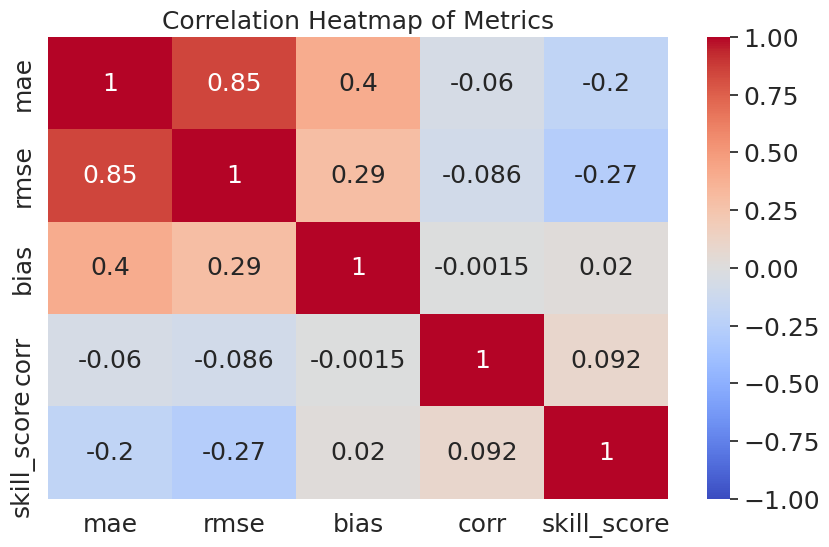

In [19]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.savefig('../images/kern/field_metric_correlation.png')

## Distribution of Metrics

In [20]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [21]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342090 entries, 0 to 342089
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  342090 non-null  datetime64[ns]
 1   field_id          342090 non-null  object        
 2   crop              342090 non-null  int64         
 3   variable          342090 non-null  object        
 4   stat              342090 non-null  object        
 5   value             342090 non-null  float64       
 6   name              342090 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 18.3+ MB


### Boxplot Distribution

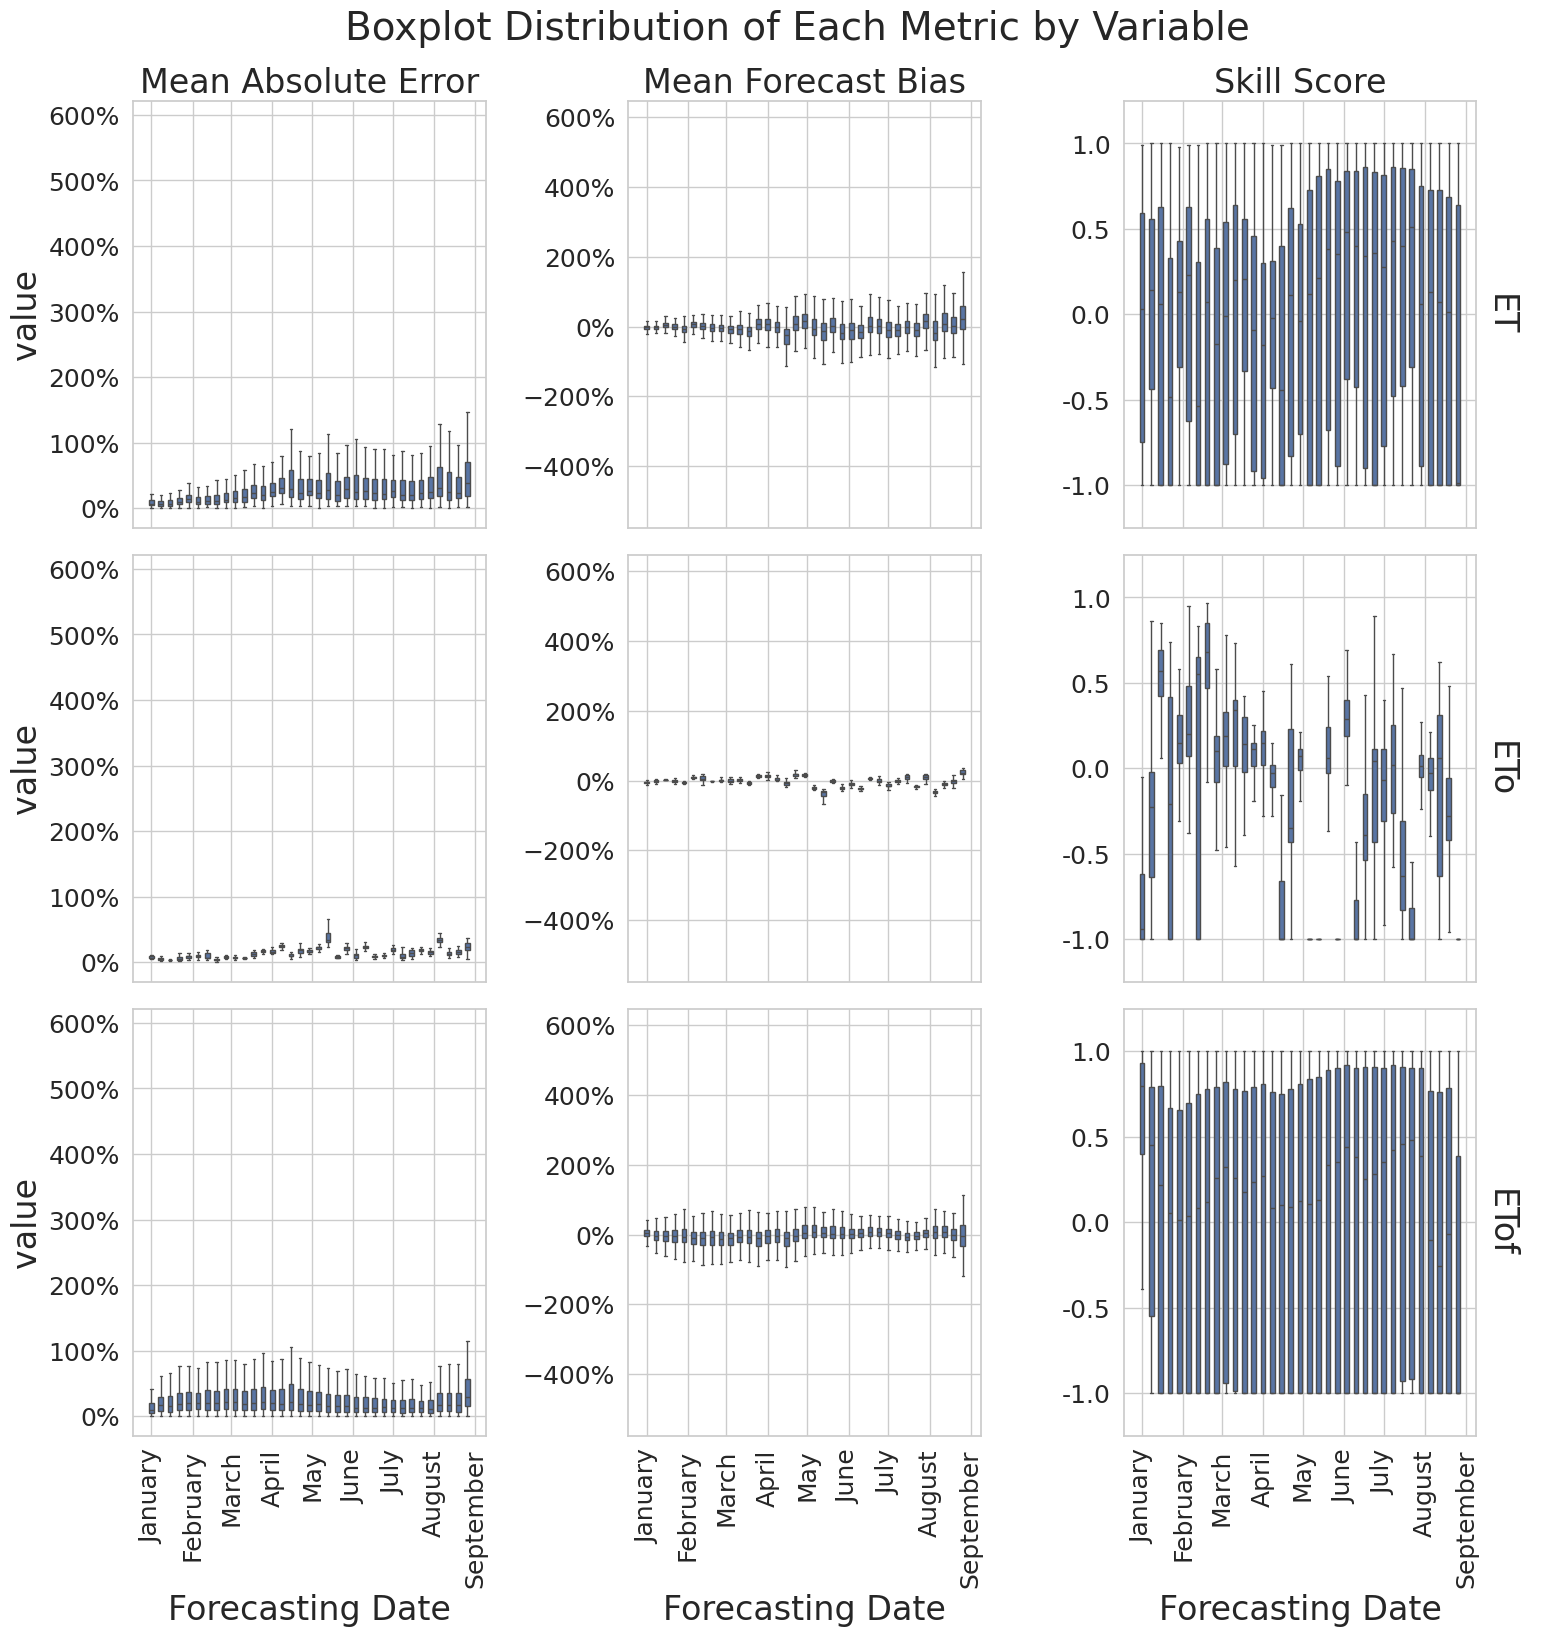

In [22]:
rel = timeseries_rel(data=metrics_long, plot='cat', kind='box',
                y='value', col='name', row='variable',
                width=0.5, errorbar='sd',
                flierprops=dict(markersize=0), title="Boxplot Distribution of Each Metric by Variable",
                as_percent=True, margin_titles=True,
                row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                facet_kws={"despine": False}, sharey='col', native_scale=True
               );
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/field_boxplots.png')

### Interquartile Metric Distrbution

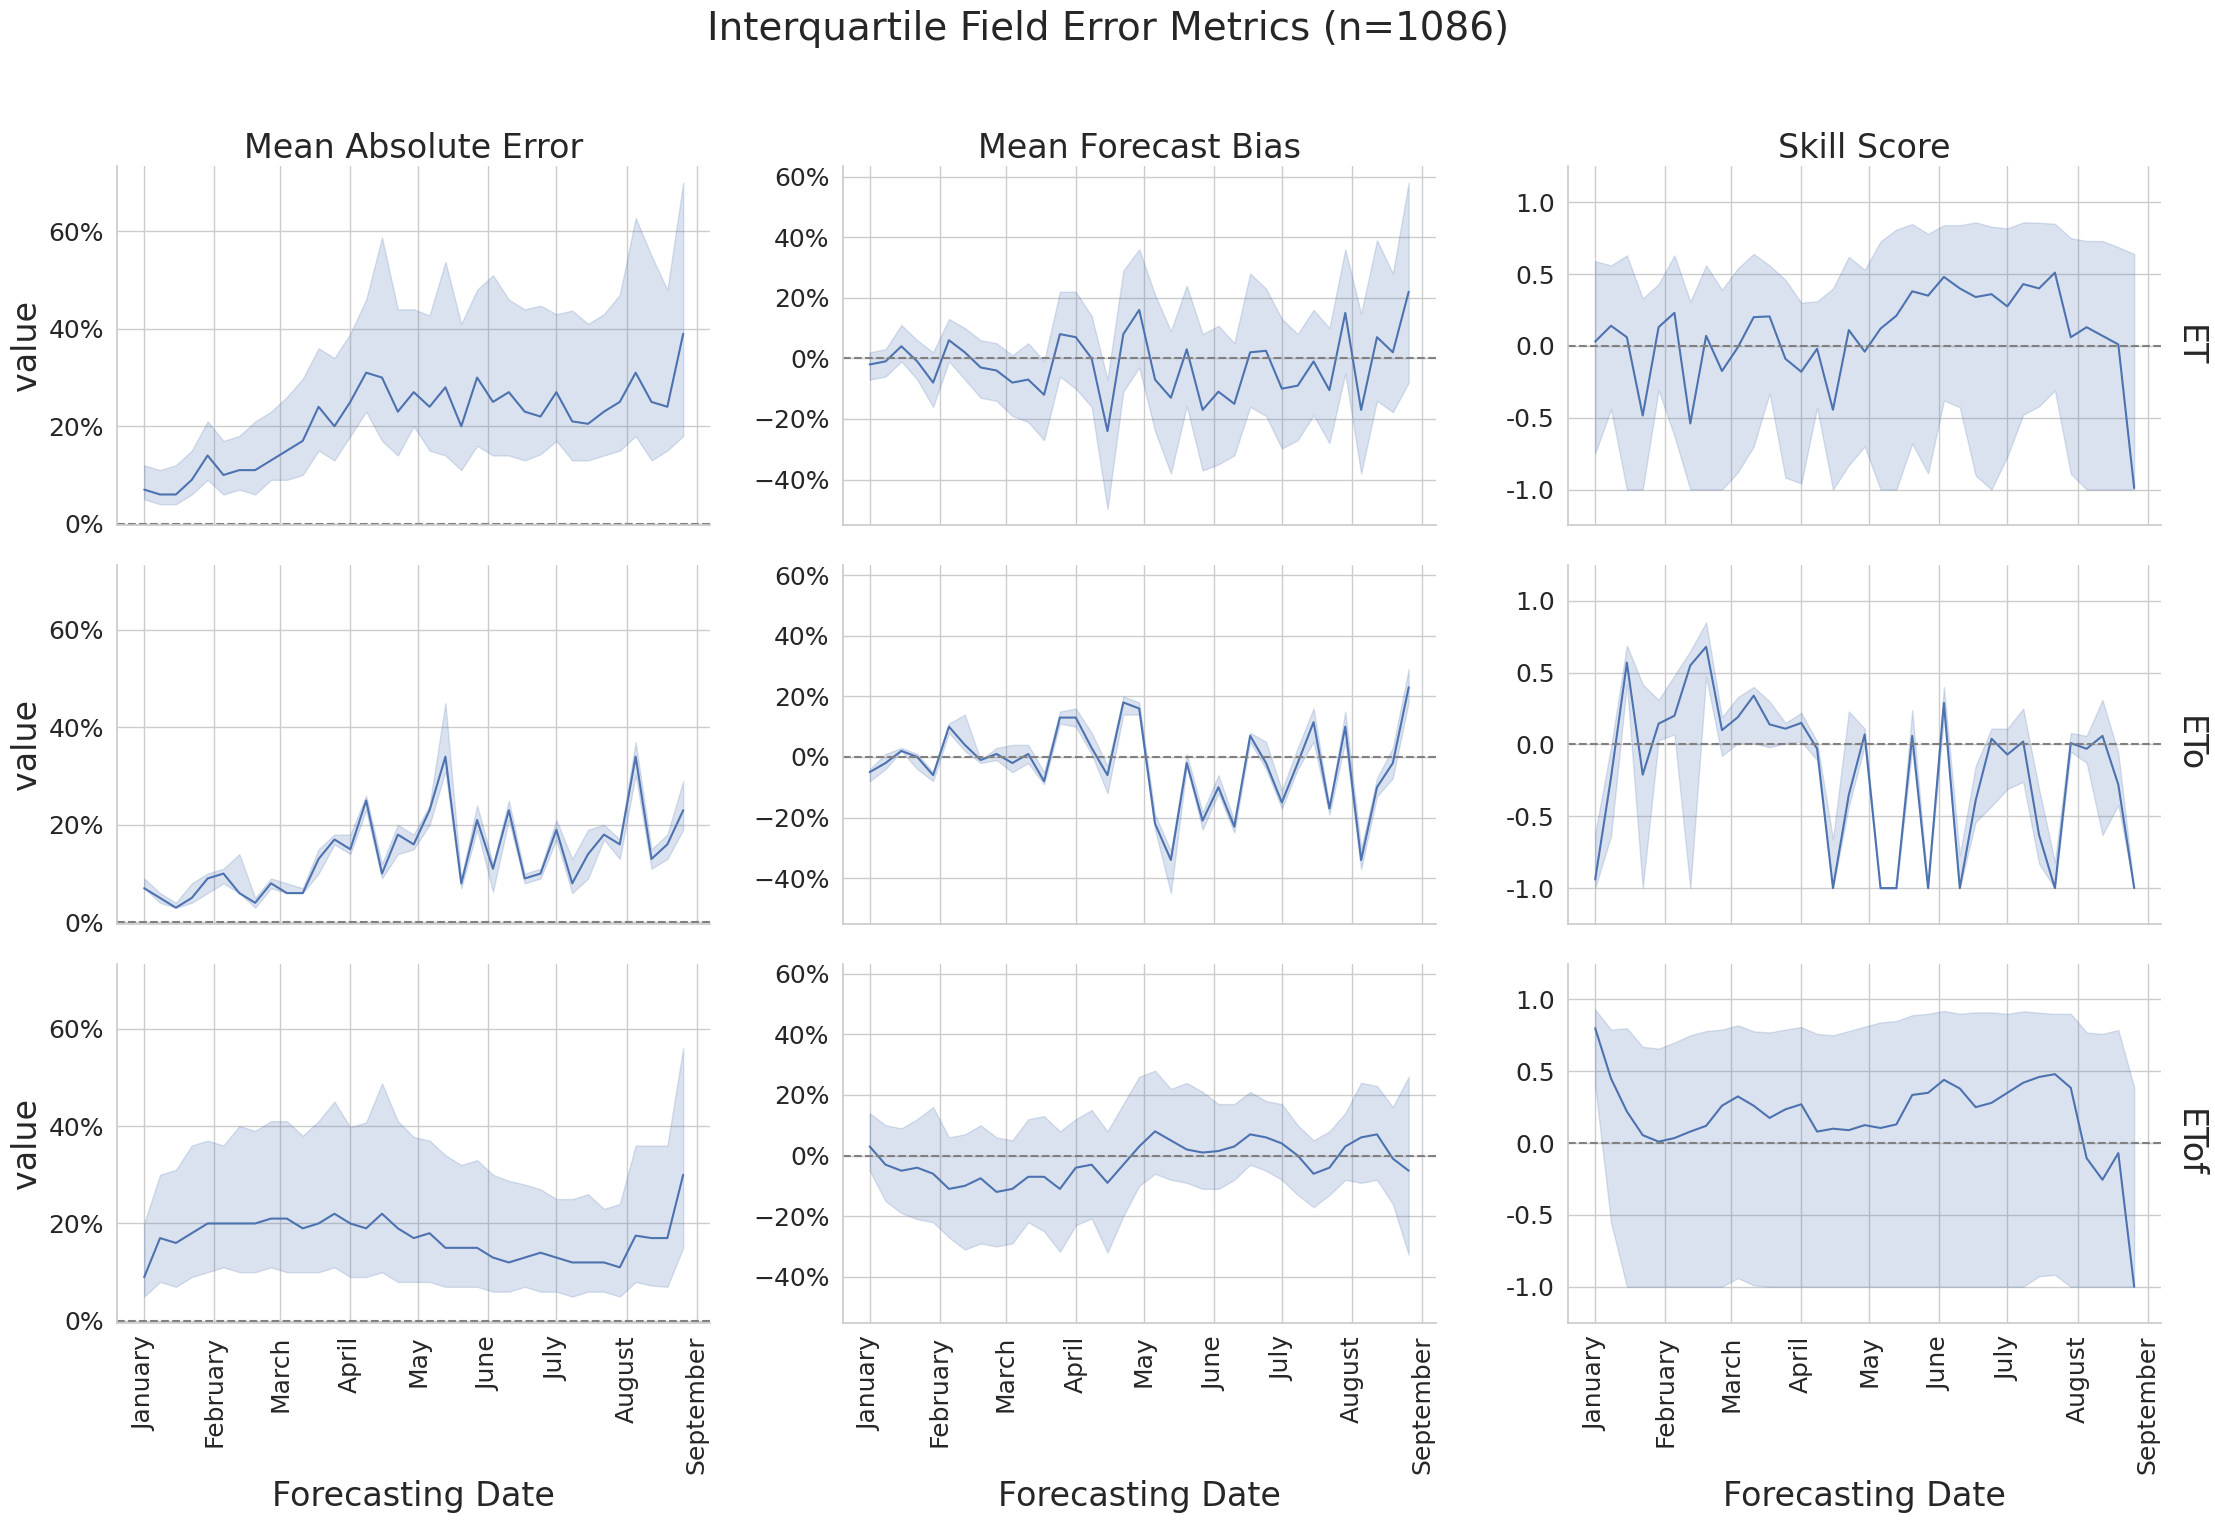

In [23]:
rel = timeseries_rel(metrics_long, row='variable', col='name', y='value',
                     errorbar=('pi', 50), estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Interquartile Field Error Metrics (n=1086)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/field_interquartile.png')

## Crop Metrics

In [24]:
# Reappend class names of crops for better readability in plots.
metrics_long = metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

In [25]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [69, 72, 75]

In [26]:
dt[dt['crop'].isin(crop_selector)].groupby('crop')['field_id'].nunique()

crop
69    181
72    130
75    228
Name: field_id, dtype: int64

In [27]:
crop_plotter = metrics_long[metrics_long['crop'].isin(crop_selector)]
crop_plotter.head()

forecasting_date   field_id  crop variable stat  value  \
1        2024-01-01  CA_297922    75     ETof  mae   0.10   
8        2024-01-01  CA_298100    69     ETof  mae   0.39   
9        2024-01-01  CA_298141    72     ETof  mae   0.17   
10       2024-01-01  CA_298142    72     ETof  mae   0.34   
11       2024-01-01  CA_298159    72     ETof  mae   0.06   

                   name Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
1   Mean Absolute Error     Almonds         0         168        132   
8   Mean Absolute Error      Grapes       112          68        137   
9   Mean Absolute Error      Citrus       255         255        128   
10  Mean Absolute Error      Citrus       255         255        128   
11  Mean Absolute Error      Citrus       255         255        128   

    Erdas_Red  Erdas_Green  Erdas_Blue  
1      0.0000       0.6471      0.5098  
8      0.4392       0.2667      0.5373  
9      1.0000       1.0000      0.4980  
10     1.0000       1.0000      0.4980  
11     1.0000       1.0000      0.4980

### Probability Distributions

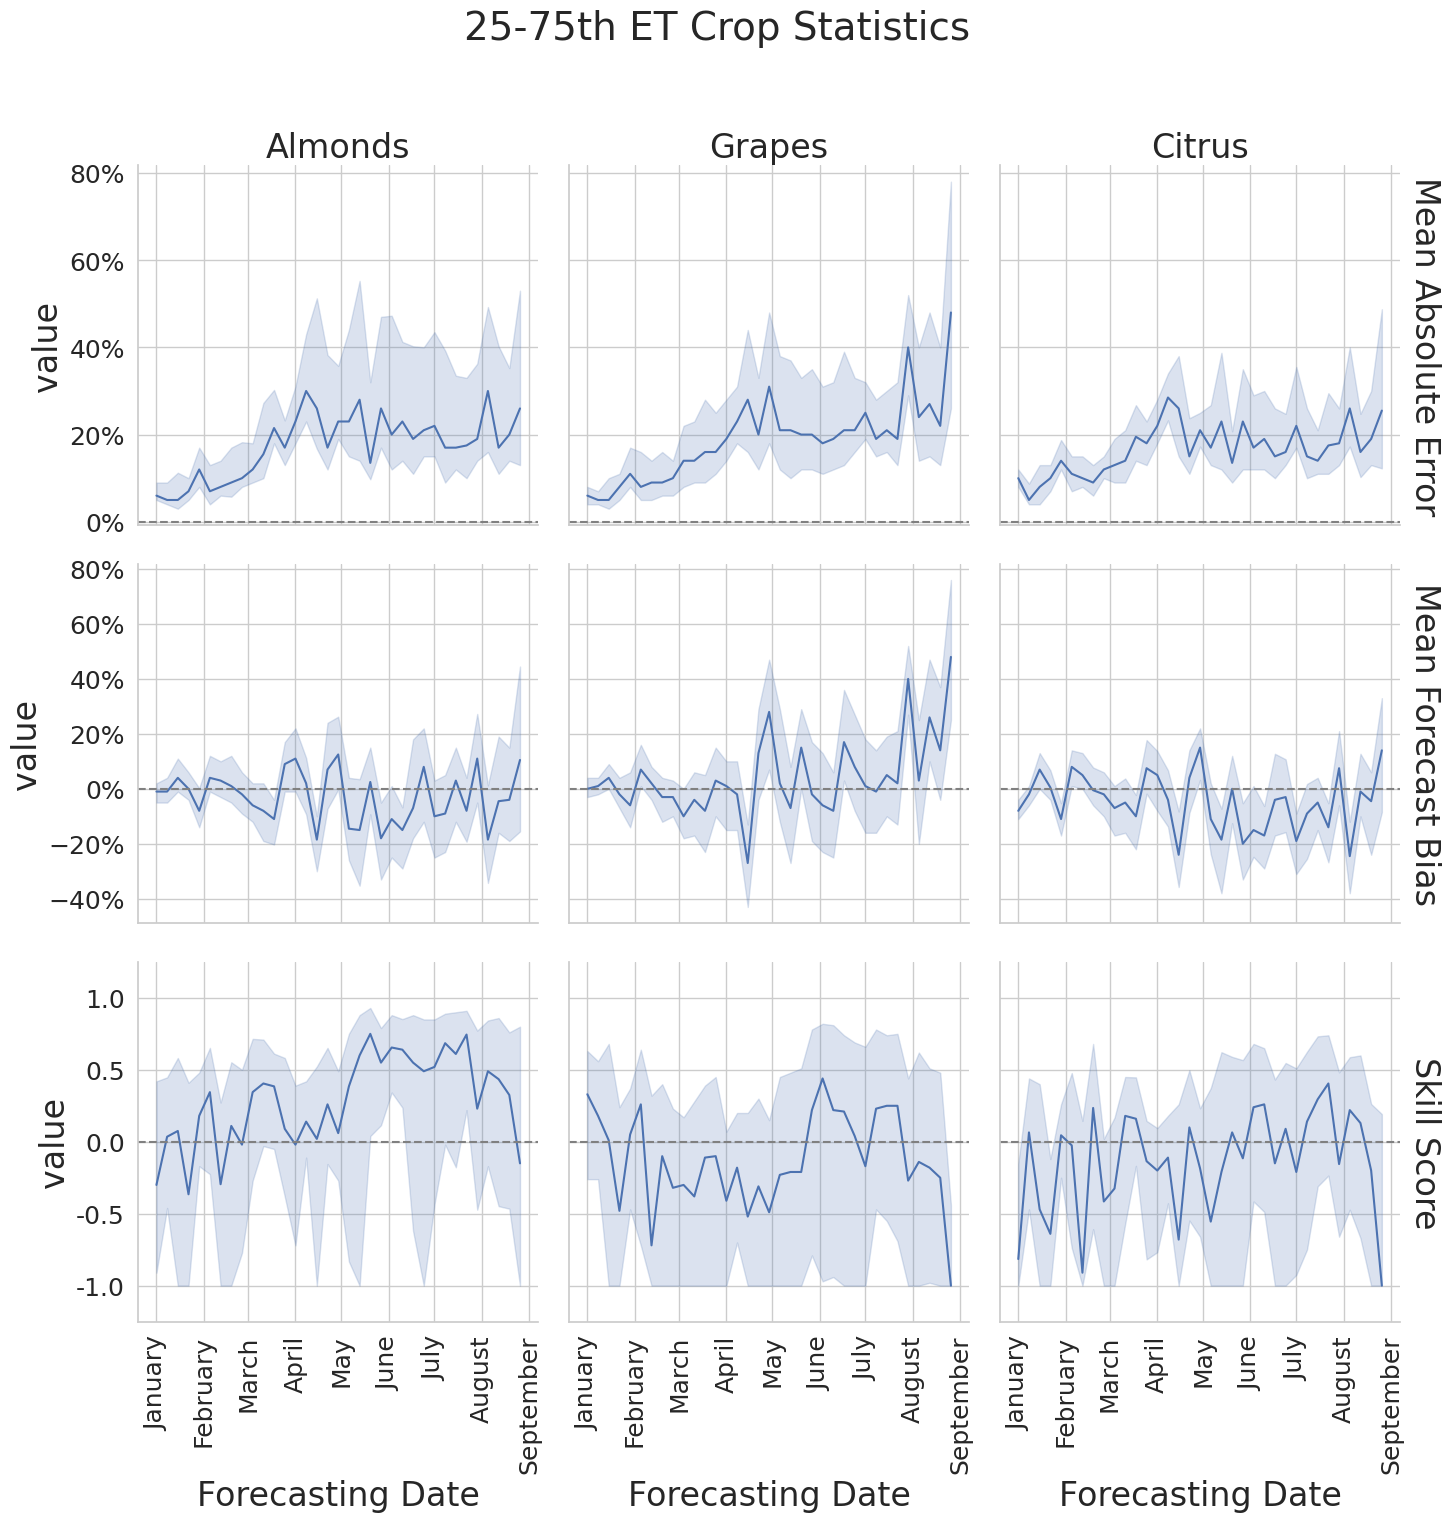

In [28]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                col='Class_Names', row='name',
                refline={'y': 0},
                facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True}, 
                estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                title='25-75th ET Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/et_crop_stats.png")

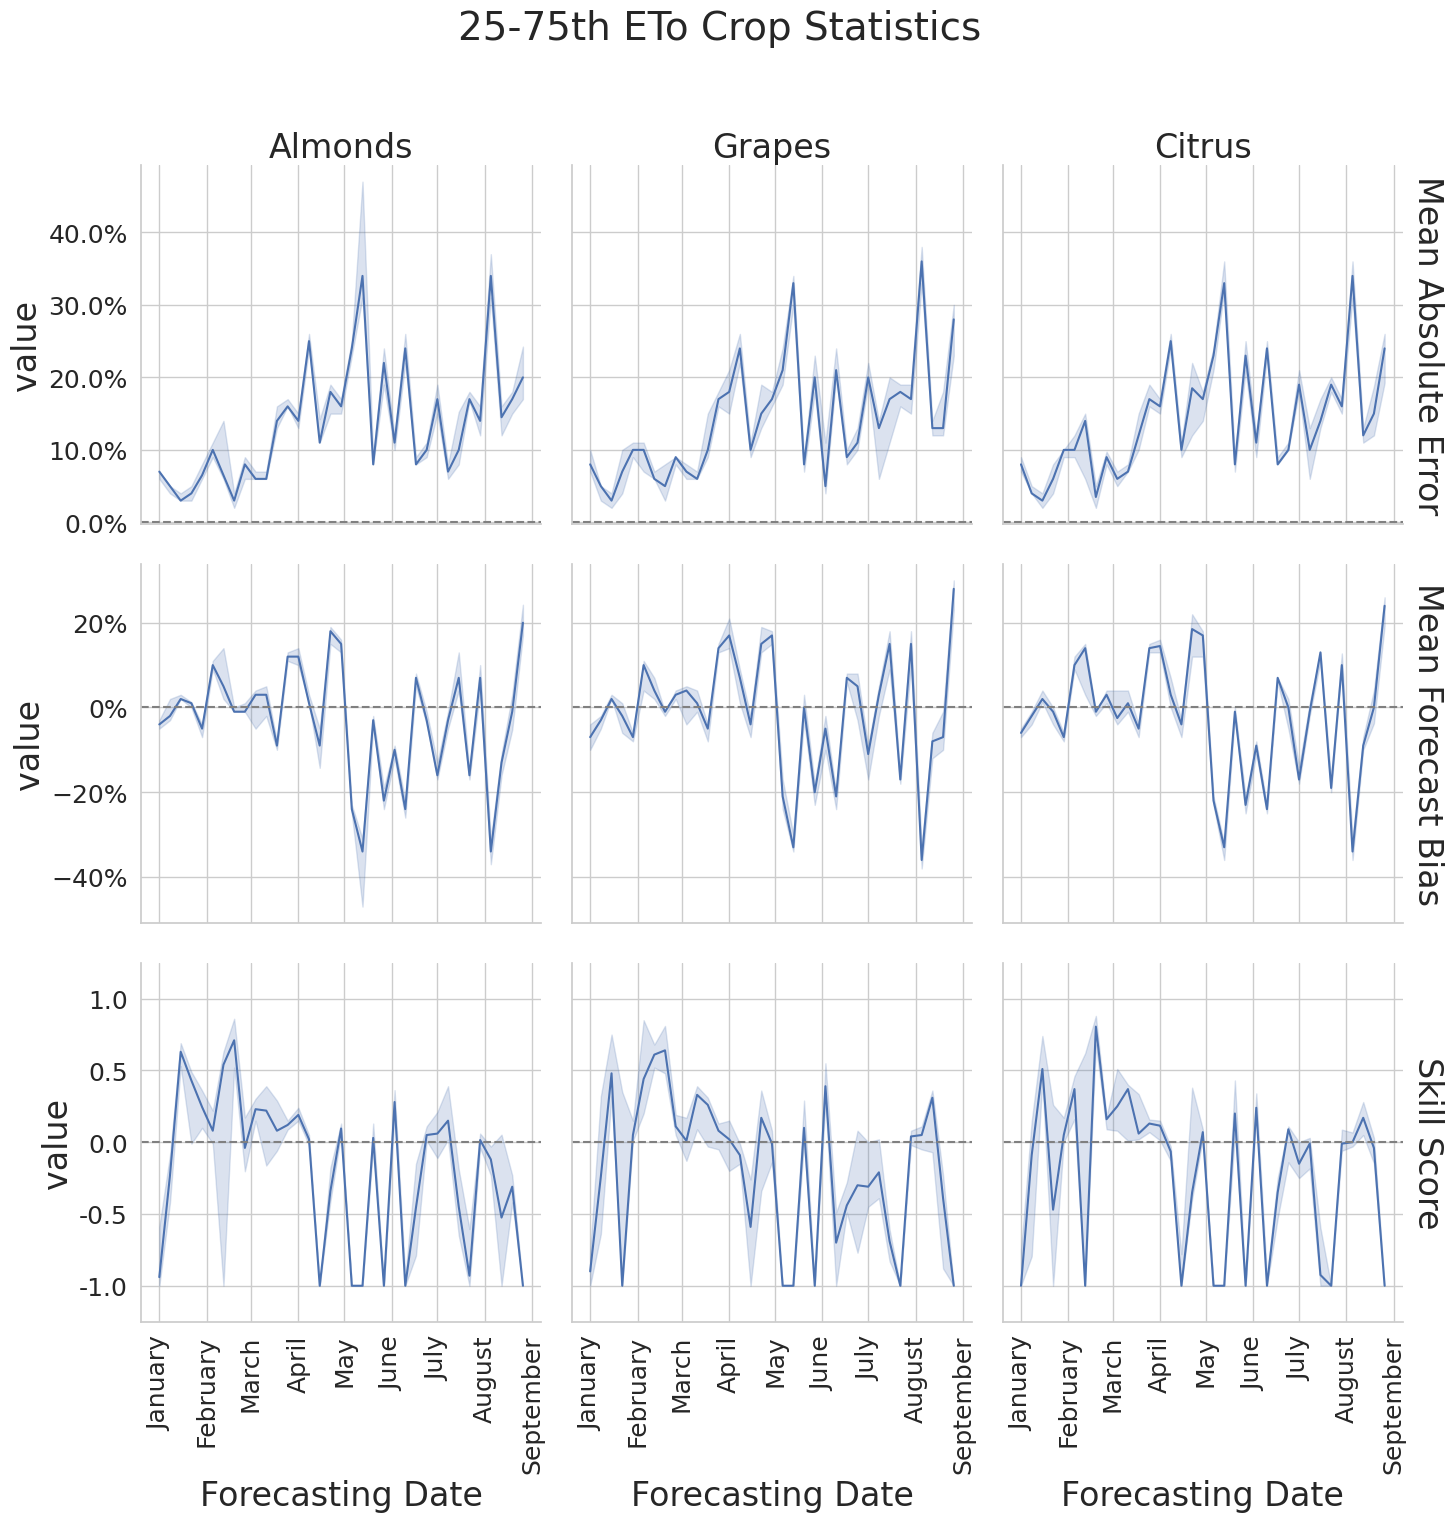

In [29]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, "margin_titles": True},
                            refline={'y': 0},
                            estimator=np.median, title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETo Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/eto_crop_stats.png")

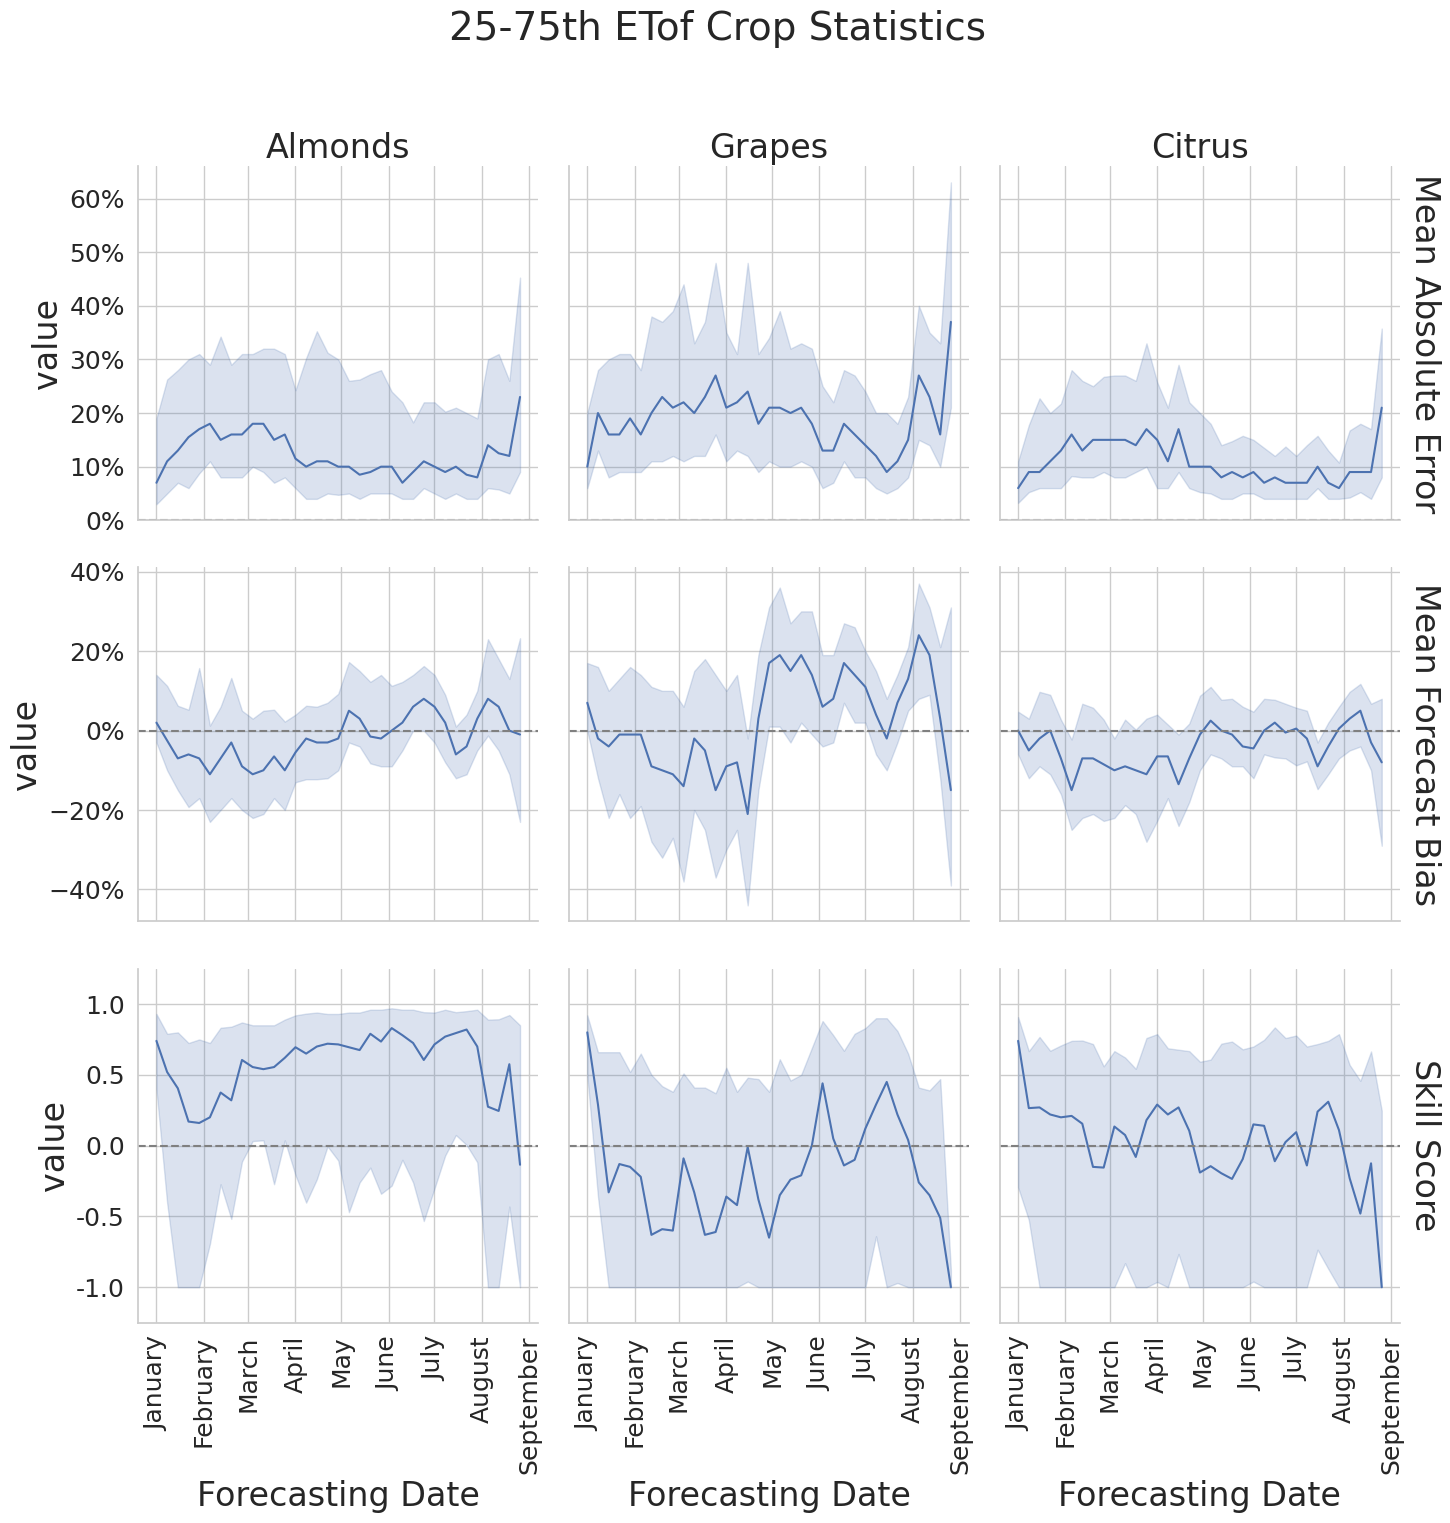

In [30]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True},
                            refline={'y': 0},
                            estimator=np.median, title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETof Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/etof_crop_stats.png")

## Alignment

In [31]:
df = dt[(dt['time'] >= (dt['forecasting_date'])) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
df = df.sort_values(by=['forecasting_date', 'field_id'])
df.head()

forecasting_date  field_id  crop       time  actual_et  actual_eto  \
1987380       2024-01-01  CA_27267    61 2024-01-01      0.043       0.951   
1987381       2024-01-01  CA_27267    61 2024-01-02      0.030       0.740   
1987382       2024-01-01  CA_27267    61 2024-01-03      0.062       1.691   
1987383       2024-01-01  CA_27267    61 2024-01-04      0.062       1.902   
1987384       2024-01-01  CA_27267    61 2024-01-05      0.039       1.374   

         actual_etof  expected_et  expected_eto  expected_etof  \
1987380        0.045        0.043         0.951          0.045   
1987381        0.041        0.388         1.374          0.258   
1987382        0.037        0.423         1.321          0.260   
1987383        0.032        0.451         1.253          0.261   
1987384        0.028        0.447         1.242          0.263   

                  Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
1987380  Fallow/Idle Cropland       191         191        122      0.749   
1987381  Fallow/Idle Cropland       191         191        122      0.749   
1987382  Fallow/Idle Cropland       191         191        122      0.749   
1987383  Fallow/Idle Cropland       191         191        122      0.749   
1987384  Fallow/Idle Cropland       191         191        122      0.749   

         Erdas_Green  Erdas_Blue  hectares  
1987380        0.749      0.4667     2.051  
1987381        0.749      0.4667     2.051  
1987382        0.749      0.4667     2.051  
1987383        0.749      0.4667     2.051  
1987384        0.749      0.4667     2.051

In [32]:
def align_forecast(data: pd.DataFrame, adjustment=0.9):
    recorded_et = data.head(1)['actual_et'].values[0]
    recorded_eto = data.head(1)['actual_eto'].values[0]
    recorded_etof = data.head(1)['actual_etof'].values[0]

    first_et = data.head(1)['expected_et'].values[0]
    first_eto = data.head(1)['expected_eto'].values[0]
    first_etof = data.head(1)['expected_etof'].values[0]
    
    # last_obs: 0.543
    # first_f: 0.750
    # calc = (0.750 - 0.543) * 0.9 = 0.207 * 0.9 = 0.1863
    
    # get the difference of just the first forecasted date and apply it to the rest of the forecasting period
    data['expected_et'] = data['expected_et'] - (first_et - recorded_et)
    data['expected_eto'] = data['expected_eto'] - (first_eto - recorded_eto)
    data['expected_etof'] = data['expected_etof'] - (first_etof - recorded_etof)

    return data[['field_id', 'crop', 'time', 'actual_et', 'actual_eto', 'actual_etof', 'expected_et', 'expected_eto', 'expected_etof', 'Class_Names', 'ESRI_Red', 'ESRI_Green', 'ESRI_Blue', 'Erdas_Red', 'Erdas_Green', 'Erdas_Blue', 'hectares']]

In [33]:
df = df.groupby('forecasting_date').apply(align_forecast).reset_index().drop(columns='level_1')
df.head()

/tmp/ipykernel_1518359/1564193808.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('forecasting_date').apply(align_forecast).reset_index().drop(columns='level_1')


forecasting_date  field_id  crop       time  actual_et  actual_eto  \
0       2024-01-01  CA_27267    61 2024-01-01      0.043       0.951   
1       2024-01-01  CA_27267    61 2024-01-02      0.030       0.740   
2       2024-01-01  CA_27267    61 2024-01-03      0.062       1.691   
3       2024-01-01  CA_27267    61 2024-01-04      0.062       1.902   
4       2024-01-01  CA_27267    61 2024-01-05      0.039       1.374   

   actual_etof  expected_et  expected_eto  expected_etof  \
0        0.045        0.043         0.951          0.045   
1        0.041        0.388         1.374          0.258   
2        0.037        0.423         1.321          0.260   
3        0.032        0.451         1.253          0.261   
4        0.028        0.447         1.242          0.263   

            Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
0  Fallow/Idle Cropland       191         191        122      0.749   
1  Fallow/Idle Cropland       191         191        122      0.749   
2  Fallow/Idle Cropland       191         191        122      0.749   
3  Fallow/Idle Cropland       191         191        122      0.749   
4  Fallow/Idle Cropland       191         191        122      0.749   

   Erdas_Green  Erdas_Blue  hectares  
0        0.749      0.4667     2.051  
1        0.749      0.4667     2.051  
2        0.749      0.4667     2.051  
3        0.749      0.4667     2.051  
4        0.749      0.4667     2.051

### Metric Calculation

In [34]:
# alignment_metrics = df.groupby('forecasting_date').apply(eval_metrics, normalize=True)
# alignment_metrics.to_csv('./data/metrics/kern_alignment_metrics.csv')
# alignment_metrics

In [35]:
alignment_metrics = pd.read_csv('../data/metrics/kern_alignment_metrics.csv', low_memory=False).drop(columns="Unnamed: 1")
alignment_metrics['forecasting_date'] = pd.to_datetime(alignment_metrics['forecasting_date'])
alignment_metrics.head()

forecasting_date   field_id  crop   mae  rmse  corr  bias  skill_score  \
0       2024-01-01   CA_27267    61  0.34  0.28 -0.65  0.34         0.69   
1       2024-01-01  CA_297922    75  0.08  0.08 -0.46 -0.08        -0.74   
2       2024-01-01  CA_297927    61  0.05  0.04  0.99 -0.05         0.99   
3       2024-01-01  CA_297932   204  0.16  0.11 -0.33 -0.16         0.92   
4       2024-01-01  CA_297950   204  0.29  0.19 -0.98  0.29         0.53   

  variable  
0     ETof  
1     ETof  
2     ETof  
3     ETof  
4     ETof

### Visualization

In [36]:
alignment_metrics_long = alignment_metrics.reset_index().melt(
    id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
alignment_metrics_long

forecasting_date   field_id  crop variable         stat  value
0            2024-01-01   CA_27267    61     ETof          mae   0.34
1            2024-01-01  CA_297922    75     ETof          mae   0.08
2            2024-01-01  CA_297927    61     ETof          mae   0.05
3            2024-01-01  CA_297932   204     ETof          mae   0.16
4            2024-01-01  CA_297950   204     ETof          mae   0.29
...                 ...        ...   ...      ...          ...    ...
302989       2024-07-29   CA_42274    69       ET  skill_score   0.22
302990       2024-07-29   CA_42289    47       ET  skill_score  -1.00
302991       2024-07-29   CA_42338    47       ET  skill_score   0.05
302992       2024-07-29   CA_42345    69       ET  skill_score  -0.20
302993       2024-07-29  CA_423678    61       ET  skill_score   0.97

[302994 rows x 6 columns]

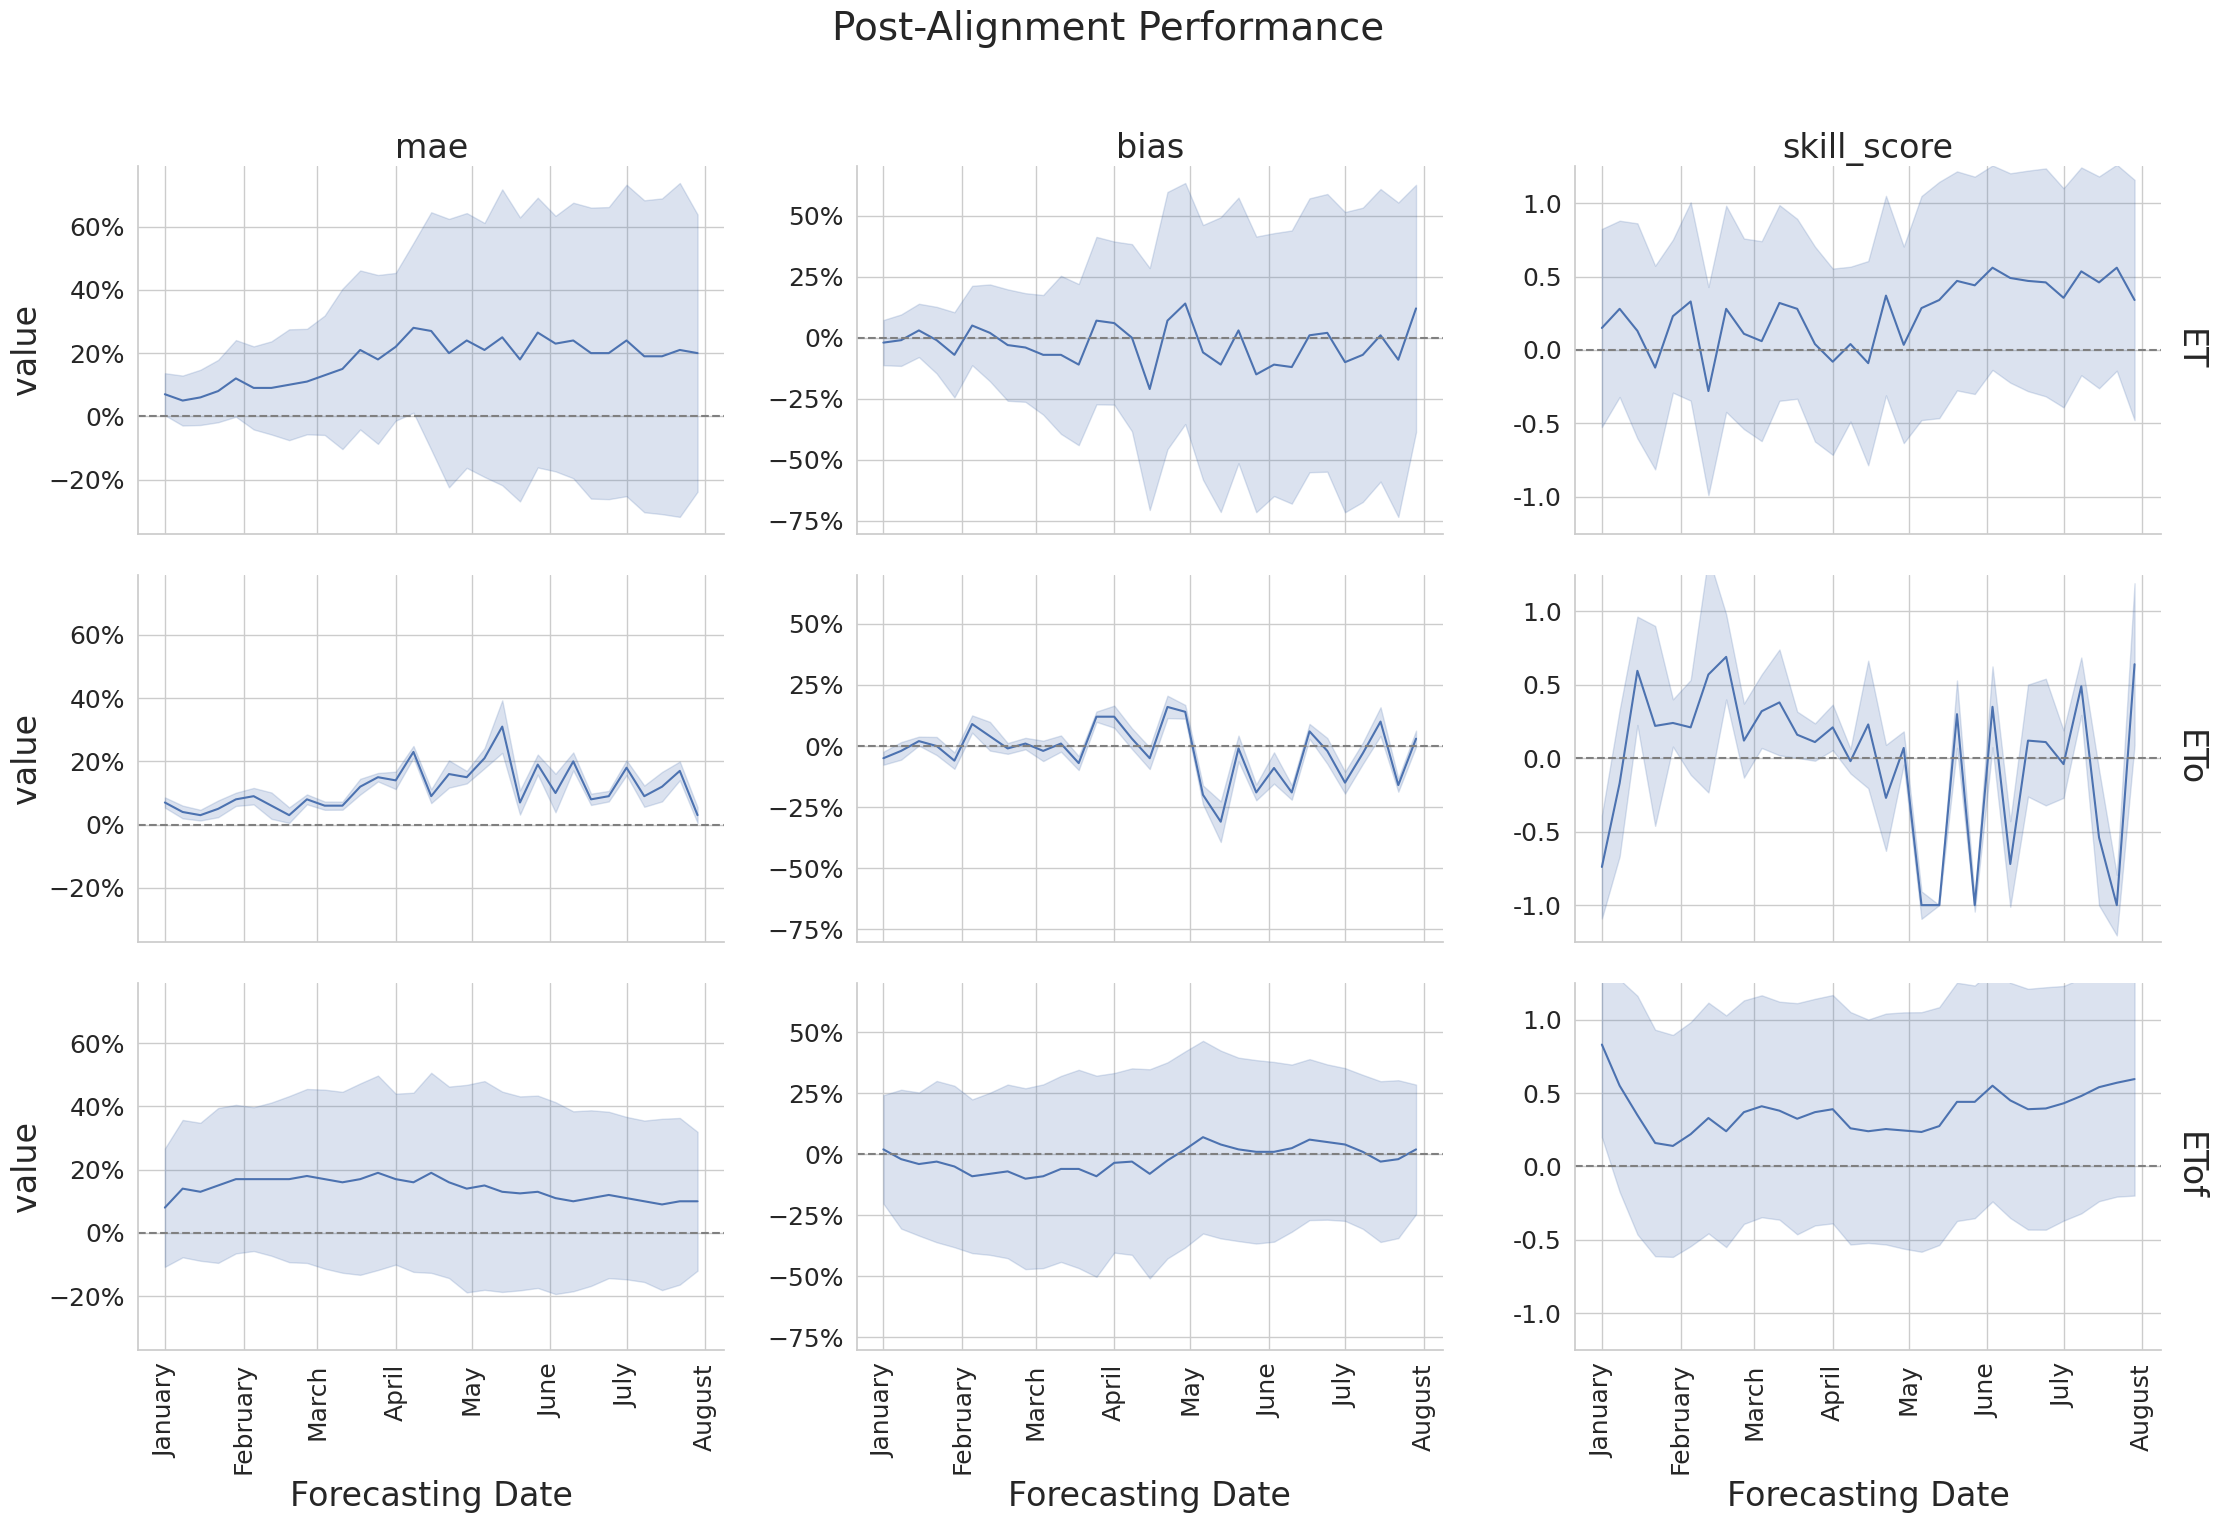

In [37]:
rel = timeseries_rel(alignment_metrics_long, row='variable', col='stat', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Post-Alignment Performance");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/alignment_sd.png')

In [38]:
alignment_metrics_long['aligned'] = True
metrics_long['aligned'] = False

alignment_metrics_cmp = pd.concat([alignment_metrics_long, metrics_long])
alignment_metrics_cmp

forecasting_date   field_id  crop variable         stat  value  \
0            2024-01-01   CA_27267    61     ETof          mae   0.34   
1            2024-01-01  CA_297922    75     ETof          mae   0.08   
2            2024-01-01  CA_297927    61     ETof          mae   0.05   
3            2024-01-01  CA_297932   204     ETof          mae   0.16   
4            2024-01-01  CA_297950   204     ETof          mae   0.29   
...                 ...        ...   ...      ...          ...    ...   
342085       2024-08-26   CA_42274    69       ET  skill_score  -1.00   
342086       2024-08-26   CA_42289    47       ET  skill_score  -1.00   
342087       2024-08-26   CA_42338    47       ET  skill_score  -1.00   
342088       2024-08-26   CA_42345    69       ET  skill_score  -1.00   
342089       2024-08-26  CA_423678    61       ET  skill_score   0.52   

        aligned         name           Class_Names  ESRI_Red  ESRI_Green  \
0          True          NaN                   NaN       NaN         NaN   
1          True          NaN                   NaN       NaN         NaN   
2          True          NaN                   NaN       NaN         NaN   
3          True          NaN                   NaN       NaN         NaN   
4          True          NaN                   NaN       NaN         NaN   
...         ...          ...                   ...       ...         ...   
342085    False  Skill Score                Grapes     112.0        68.0   
342086    False  Skill Score    Misc Vegs & Fruits     255.0       102.0   
342087    False  Skill Score    Misc Vegs & Fruits     255.0       102.0   
342088    False  Skill Score                Grapes     112.0        68.0   
342089    False  Skill Score  Fallow/Idle Cropland     191.0       191.0   

        ESRI_Blue  Erdas_Red  Erdas_Green  Erdas_Blue  
0             NaN        NaN          NaN         NaN  
1             NaN        NaN          NaN         NaN  
2             NaN        NaN          NaN         NaN  
3             NaN        NaN          NaN         NaN  
4             NaN        NaN          NaN         NaN  
...           ...        ...          ...         ...  
342085      137.0     0.4392       0.2667      0.5373  
342086      102.0     1.0000       0.4000      0.4000  
342087      102.0     1.0000       0.4000      0.4000  
342088      137.0     0.4392       0.2667      0.5373  
342089      122.0     0.7490       0.7490      0.4667  

[645084 rows x 15 columns]

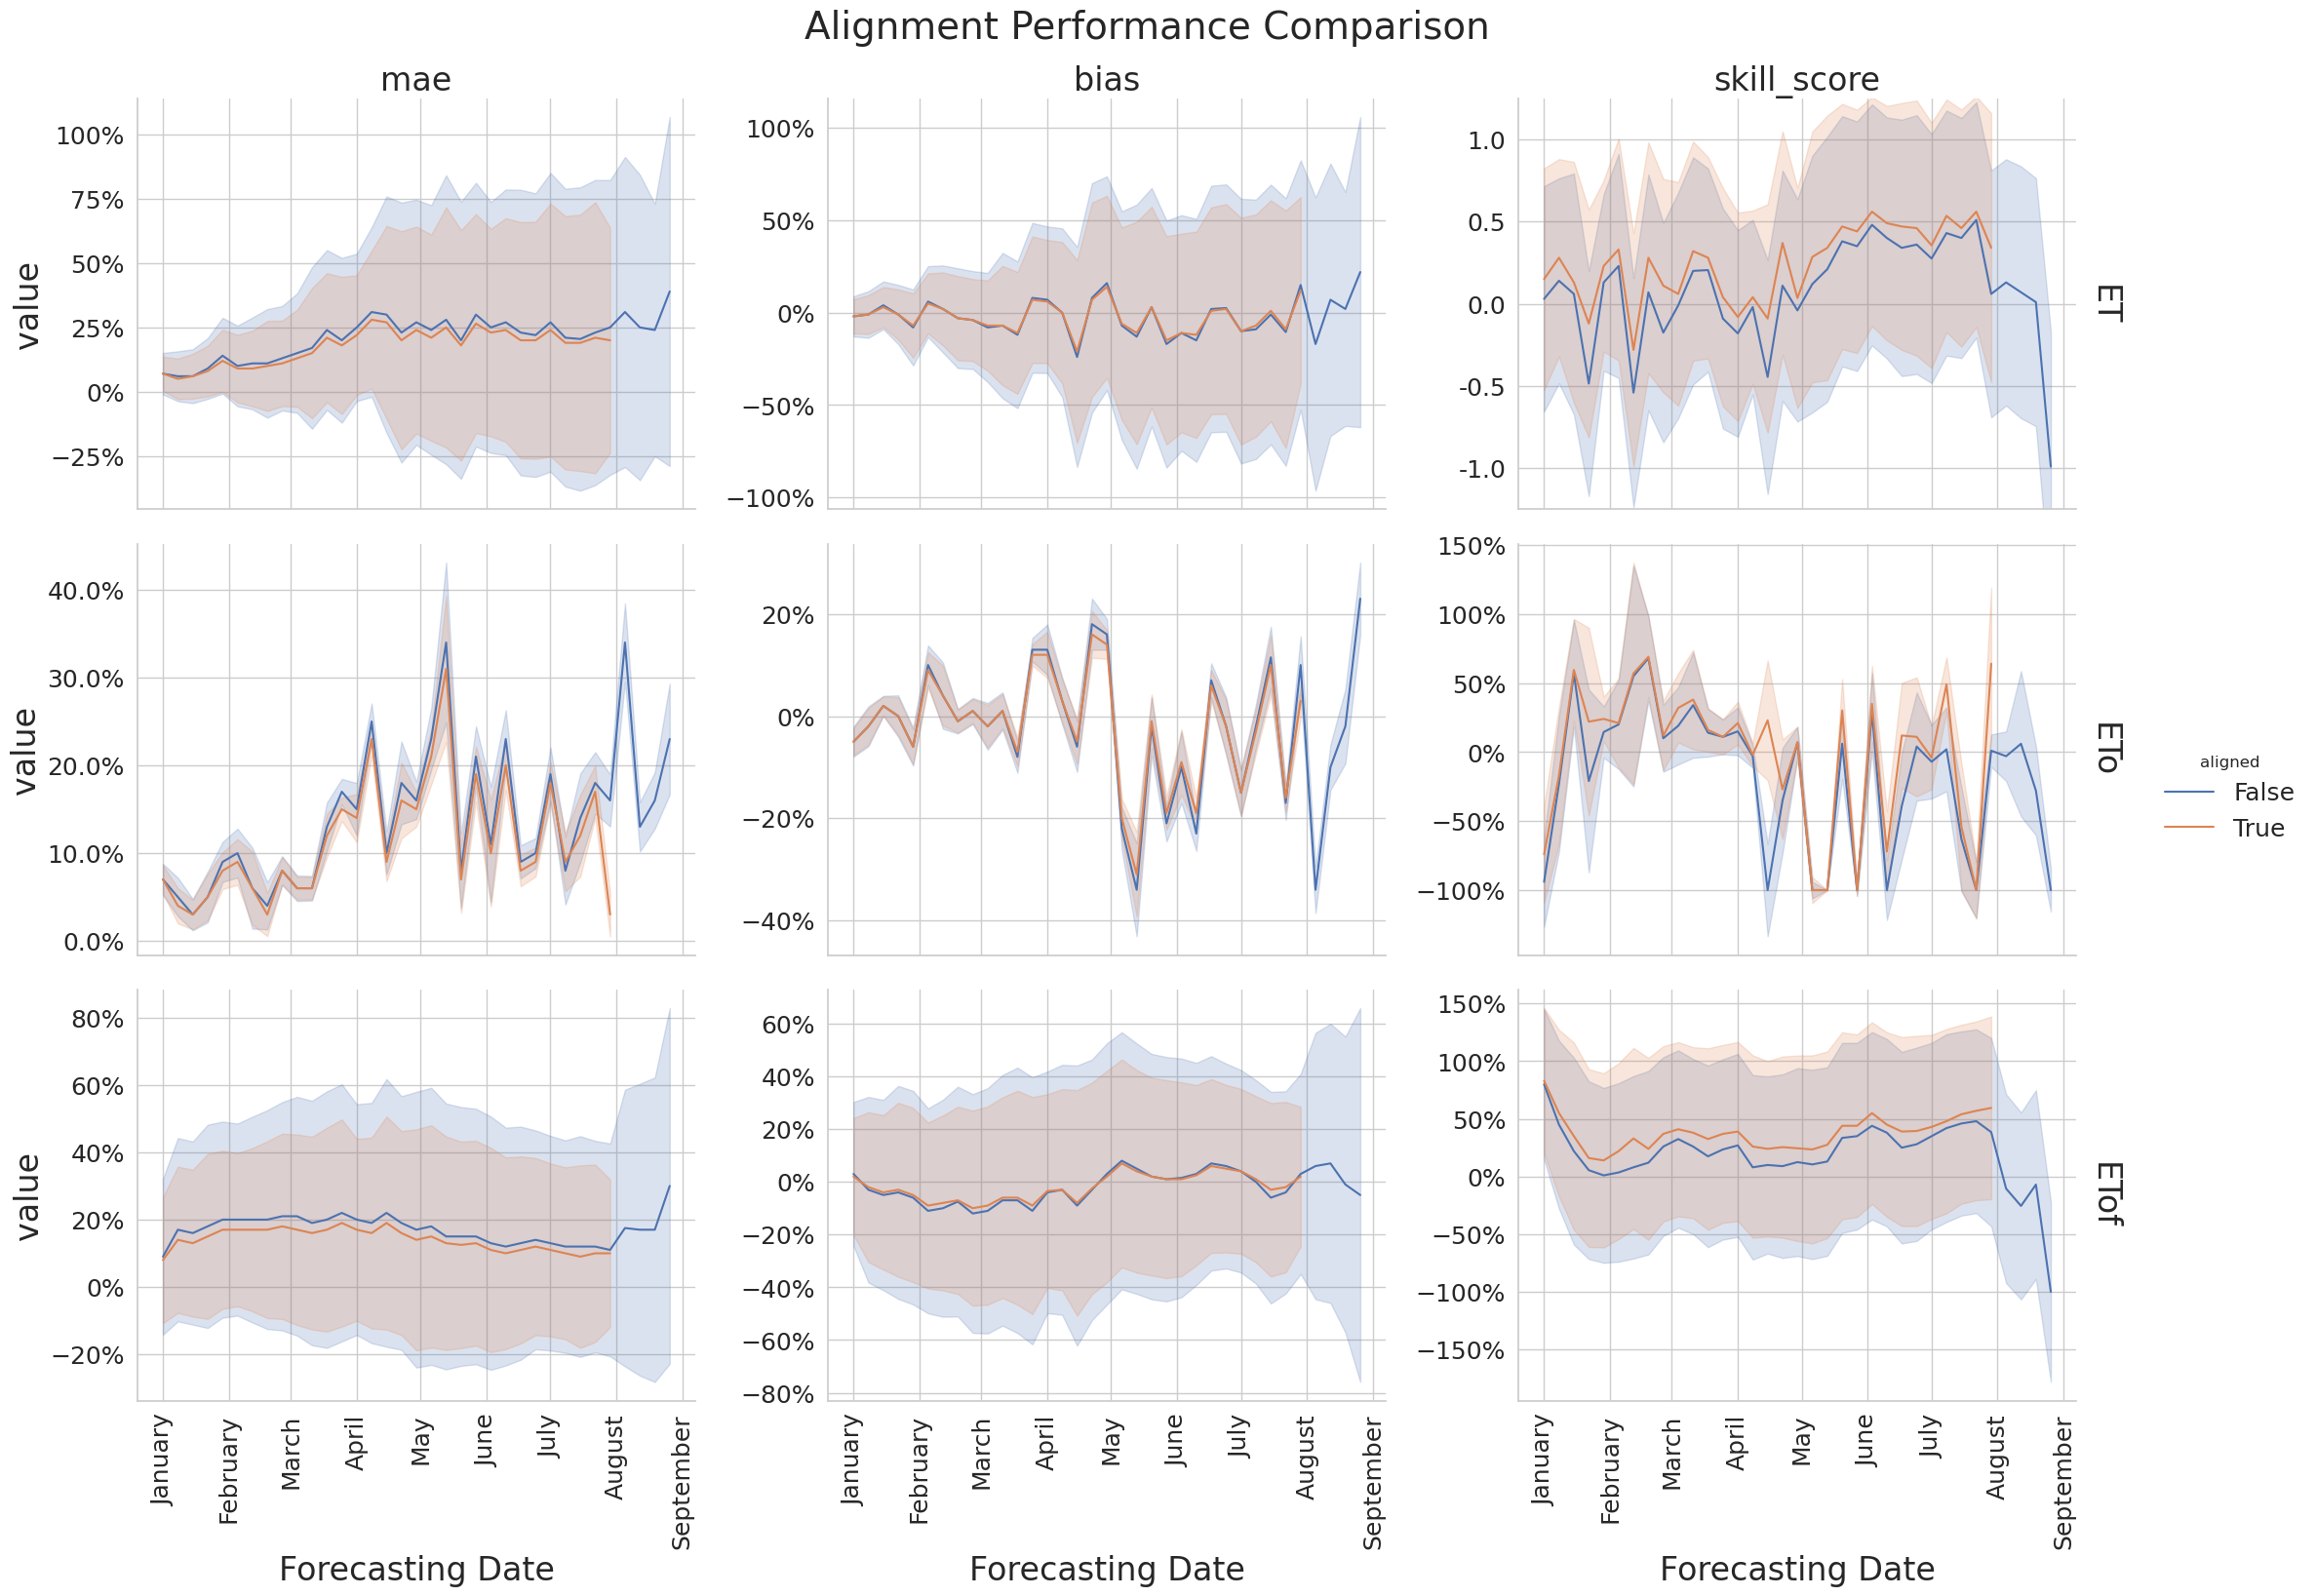

In [39]:
rel = timeseries_rel(alignment_metrics_cmp, row='variable', col='stat', y='value', hue='aligned',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Alignment Performance Comparison");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/alignment_comparison.png')

## Spatial Plotting

### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [40]:
# Define date range of seasons
winter = (datetime(year=2024, month=1, day=1), datetime(year=2024, month=3, day=20)) # Start winter at start of forecast range
spring = (datetime(year=2024, month=3, day=21), datetime(year=2024, month=6, day=20))
summer = (datetime(year=2024, month=6, day=21), datetime(year=2024, month=9, day=20))

# Create list of the forecast dates that fit the seasonal ranges
winter_forecasts = pd.Series([x for x in forecast_dates if x >= winter[0] and x <= winter[1]])
spring_forecasts = pd.Series([x for x in forecast_dates if x >= spring[0] and x <= spring[1]])
summer_forecasts = pd.Series([x for x in forecast_dates if x >= summer[0] and x <= summer[1]])

def assign_season(x):
    season = ""
    if winter_forecasts.isin([x['forecasting_date']]).any():
        season = "Winter"
    elif spring_forecasts.isin([x['forecasting_date']]).any():
        season = "Spring"
    elif summer_forecasts.isin([x['forecasting_date']]).any():
        season = "Summer"
    return pd.Series({'season': season})

In [41]:
# Create column that defines a row's season
seasonal_metrics = metrics_norm.reset_index().sort_values(by='forecasting_date').merge(metrics_norm.reset_index().apply(assign_season, axis=1), left_index=True, right_index=True)

# Combine all forecasts for each field by getting mean of forecast metrics.
seasonal_metrics = seasonal_metrics.groupby(['field_id', 'season', 'variable'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)

# Add positional columns
seasonal_metrics = seasonal_metrics.join(kern_geo, how='left', on='field_id', validate='many_to_one')
# Add field size column for marker size
seasonal_metrics = seasonal_metrics.join(field_metadata, how='left', on='field_id', validate='many_to_one')
# Calculate marker size
seasonal_metrics['markersize'] = seasonal_metrics.apply(lambda x: np.max(np.divmod(x['hectares'] / 10, 10)[1], initial=2.0), axis=1)

seasonal_metrics.reset_index(inplace=True)
seasonal_metrics.dropna(inplace=True)
seasonal_metrics

field_id  season variable   mae  rmse  bias  corr  skill_score  \
0     CA_27267  Spring       ET  0.60  0.97 -0.52  0.09         0.33   
1     CA_27267  Spring      ETo  0.20  0.54 -0.07  0.24        -0.41   
2     CA_27267  Spring     ETof  0.26  0.19 -0.23  0.38         0.78   
3     CA_27267  Summer       ET  0.30  0.47  0.19  0.05        -0.51   
4     CA_27267  Summer      ETo  0.18  0.47 -0.05  0.30        -0.20   
...        ...     ...      ...   ...   ...   ...   ...          ...   
9760  CA_42345  Summer      ETo  0.19  0.46 -0.04 -0.08        -0.35   
9761  CA_42345  Summer     ETof  0.30  0.26 -0.02 -0.04        -0.21   
9762  CA_42345  Winter       ET  0.10  0.22 -0.07  0.27        -0.47   
9763  CA_42345  Winter      ETo  0.08  0.21 -0.02  0.28        -0.11   
9764  CA_42345  Winter     ETof  0.24  0.21 -0.17  0.25        -0.28   

       longitude   latitude  hectares  markersize  
0    -119.969497  35.792434     2.051         2.0  
1    -119.969497  35.792434     2.051         2.0  
2    -119.969497  35.792434     2.051         2.0  
3    -119.969497  35.792434     2.051         2.0  
4    -119.969497  35.792434     2.051         2.0  
...          ...        ...       ...         ...  
9760 -119.195191  35.086790     2.762         2.0  
9761 -119.195191  35.086790     2.762         2.0  
9762 -119.195191  35.086790     2.762         2.0  
9763 -119.195191  35.086790     2.762         2.0  
9764 -119.195191  35.086790     2.762         2.0  

[9765 rows x 12 columns]

#### Import regional polygon

In [42]:
keco_geo = gpd.read_file("../data/geo/Kern_County_Boundary.geojson")
keco_geo

FID  Kern_KERN_  PERIMETER    ACRES       MUNICI_ID  AREA_SQMI  ACRES_1  \
0    1           0          0  5223552  COUNTY OF KERN     8161.8        0   

     SHAPE_area     SHAPE_len   Shape__Area  Shape__Length  \
0  227638346939  2.305833e+06  3.185696e+10  862020.384235   

                                            geometry  
0  POLYGON ((-120.19438 35.78937, -120.17914 35.7...

### Seasonal Overview

#### ET Visualization

In [43]:
et_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ET']

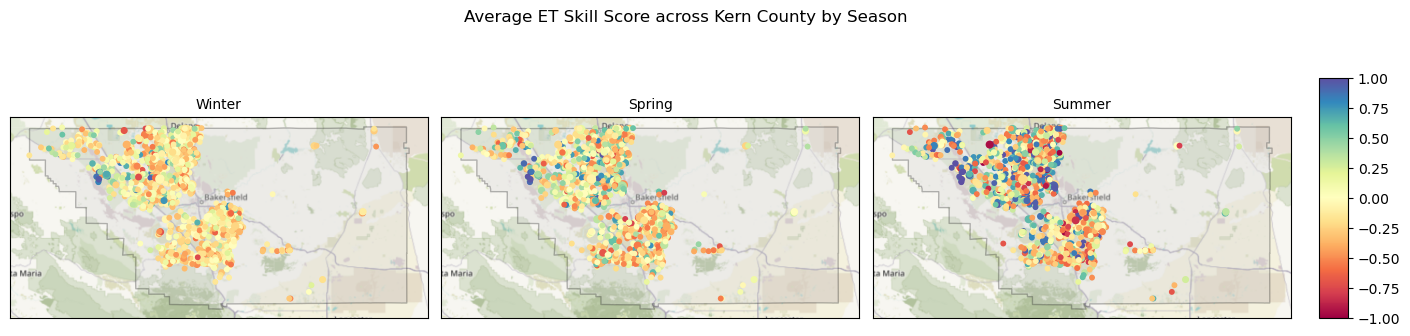

In [44]:
catplot_geo(et_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', palette='Spectral', size='markersize',
                 as_percent=False, normalize_cmap=True, export_img="kern/et_spatial_skill_score", 
                 col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                 title="Average ET Skill Score across Kern County by Season", background=True);

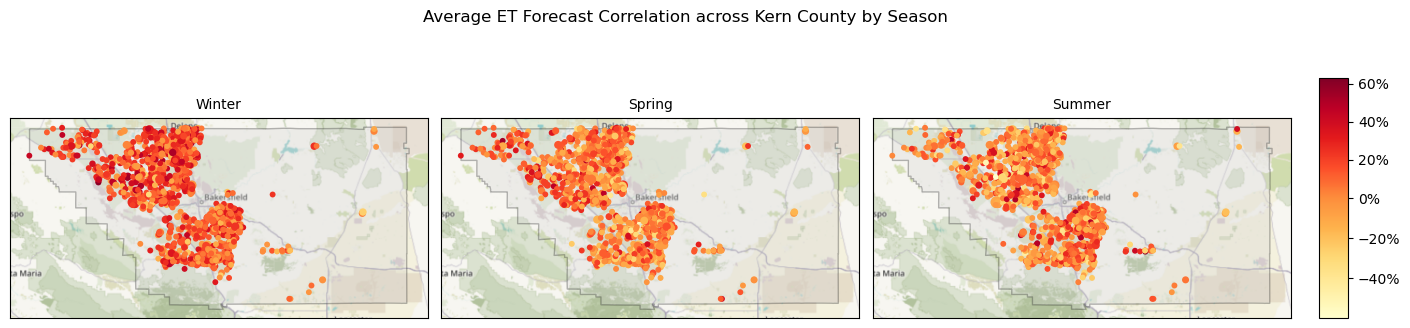

In [45]:
catplot_geo(et_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="kern/et_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Correlation across Kern County by Season", background=True);

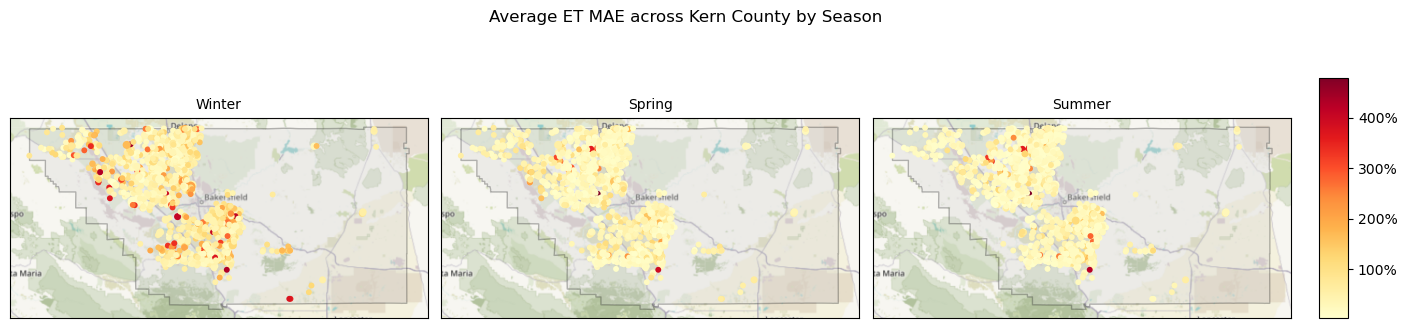

In [46]:
catplot_geo(et_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="kern/et_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET MAE across Kern County by Season", background=True);

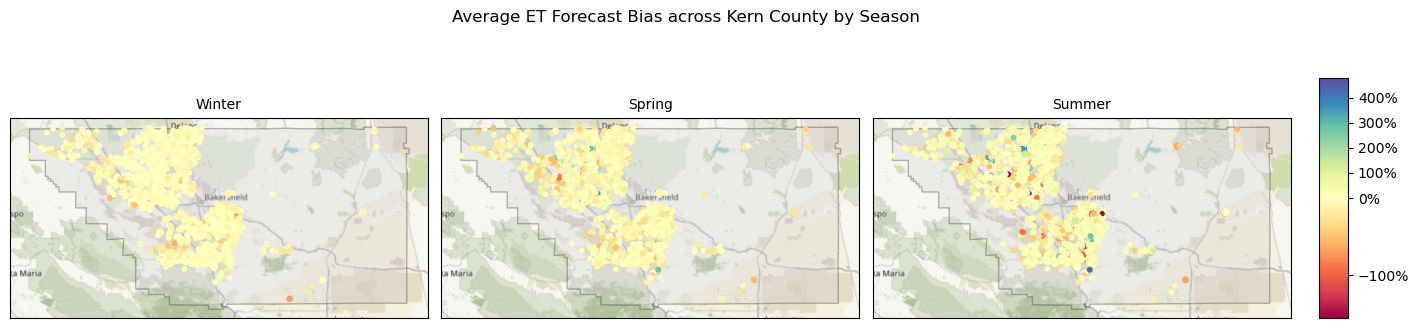

In [47]:
catplot_geo(et_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="kern/et_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Bias across Kern County by Season", background=True);

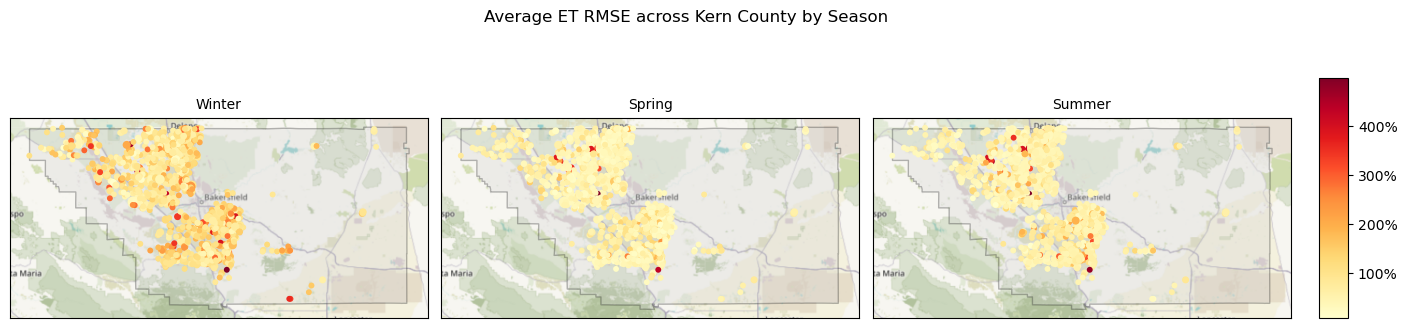

In [48]:
catplot_geo(et_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="kern/et_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET RMSE across Kern County by Season", background=True);

#### ETo Visualization

In [49]:
eto_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETo']

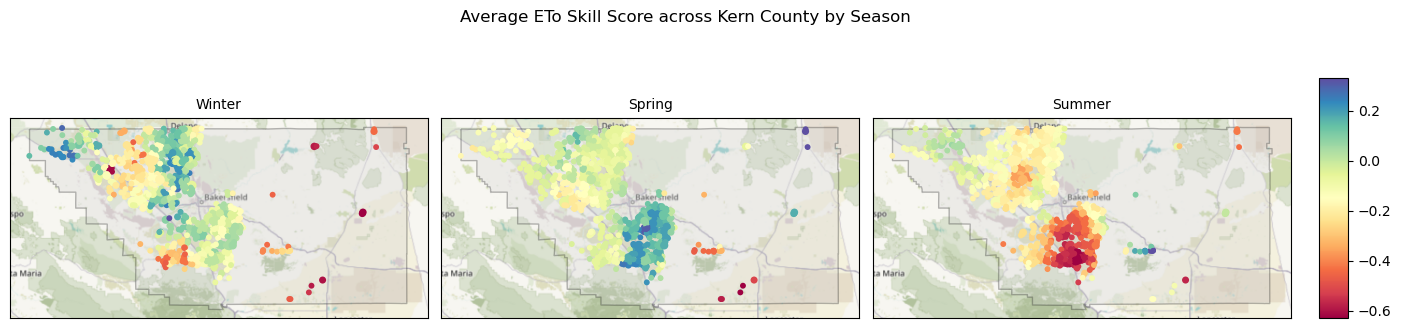

In [50]:
catplot_geo(eto_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', export_img="kern/eto_spatial_skill_score", as_percent=False, size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"}, # normalize_cmap=True,
                     title="Average ETo Skill Score across Kern County by Season", palette='Spectral', background=True);

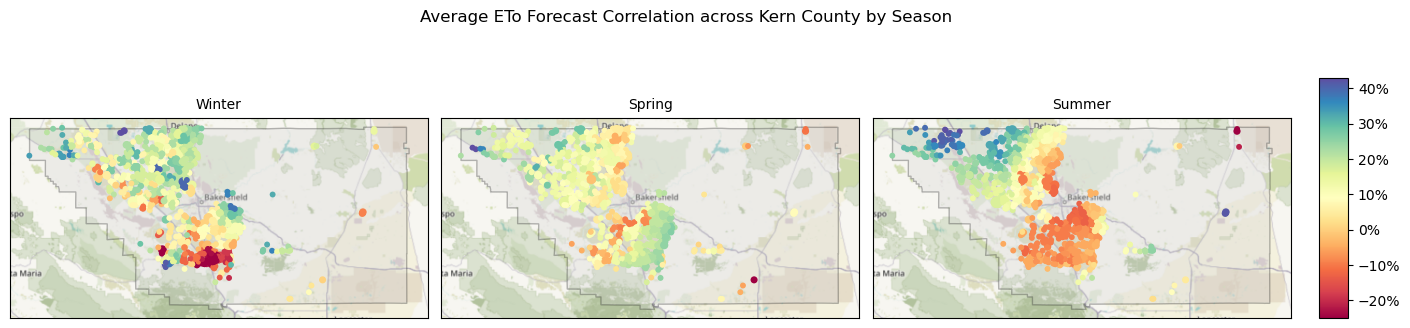

In [51]:
catplot_geo(eto_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="kern/eto_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},# normalize_cmap=True,
                     title="Average ETo Forecast Correlation across Kern County by Season", palette='Spectral', background=True);

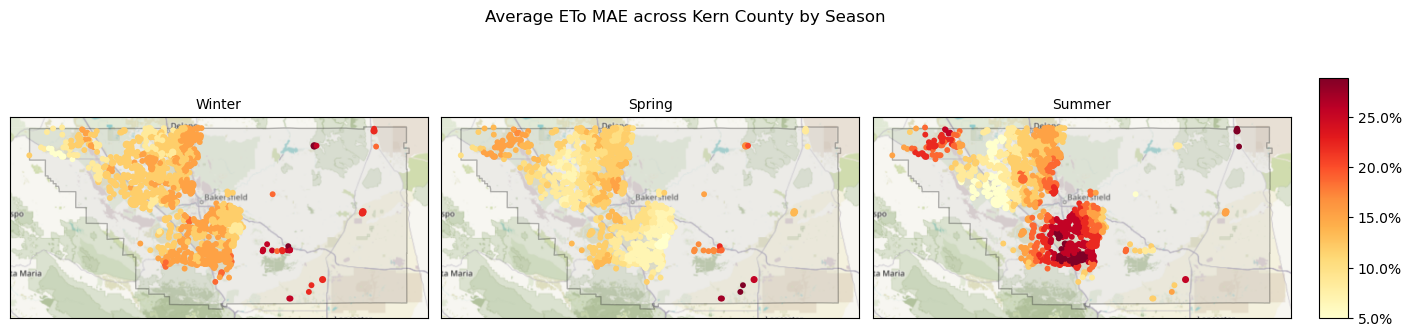

In [52]:
catplot_geo(eto_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="kern/eto_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo MAE across Kern County by Season", background=True);

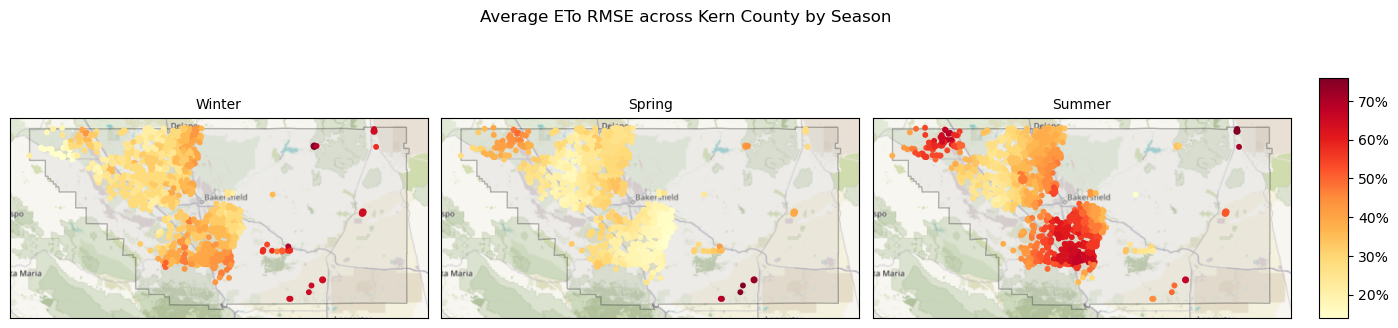

In [53]:
catplot_geo(eto_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="kern/eto_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo RMSE across Kern County by Season", background=True);

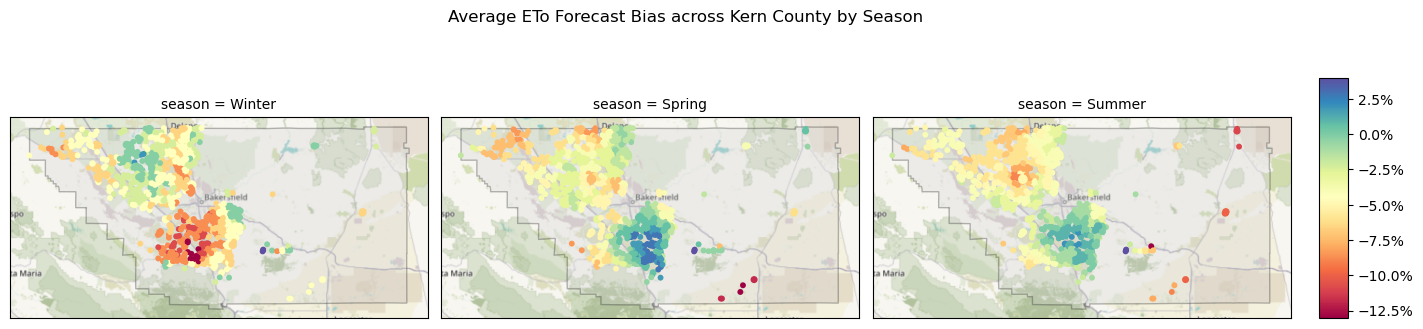

In [54]:
catplot_geo(eto_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="kern/eto_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'],# normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Forecast Bias across Kern County by Season", background=True);

#### EToF Visualization

In [55]:
etof_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETof']

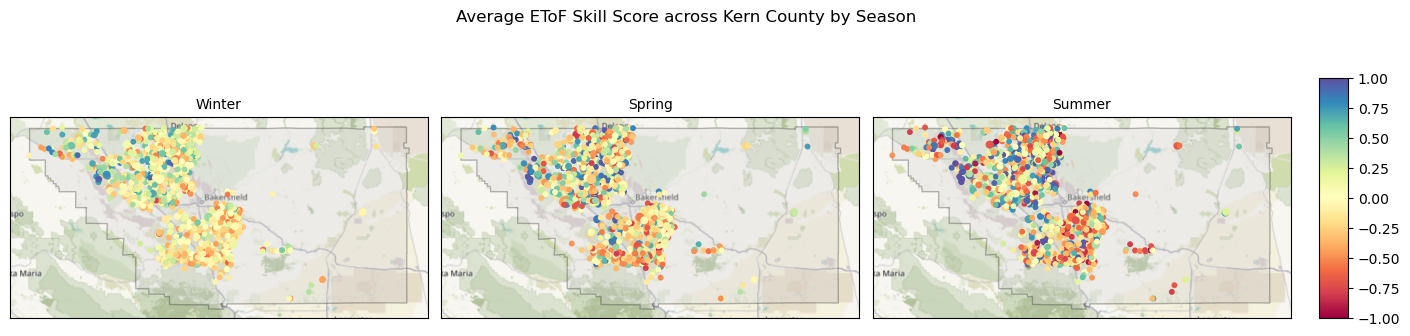

In [56]:
catplot_geo(etof_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', size='markersize', export_img="kern/etof_spatial_skill_score", as_percent=False,
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Skill Score across Kern County by Season", palette='Spectral', background=True);

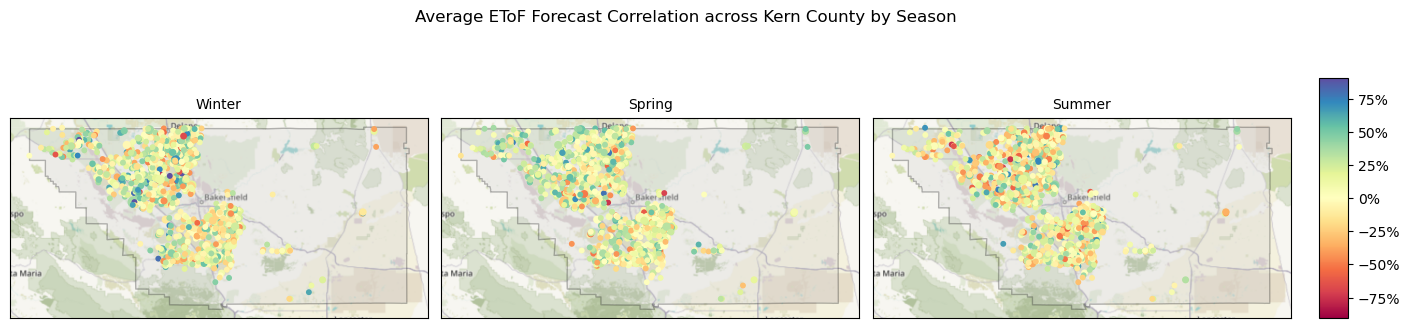

In [57]:
catplot_geo(etof_seasonal, boundary_map=keco_geo, col='season', hue='corr', size='markersize', export_img="kern/etof_spatial_corr",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Correlation across Kern County by Season", palette='Spectral', background=True);

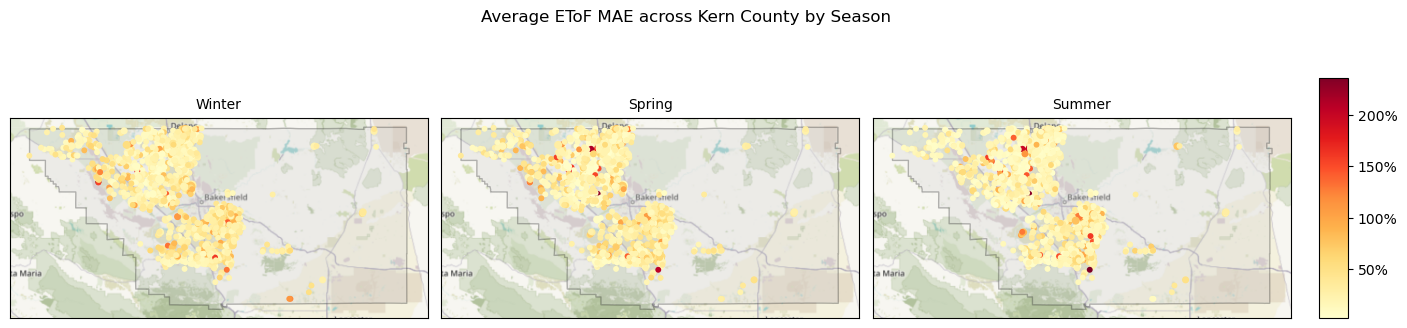

In [58]:
catplot_geo(etof_seasonal, boundary_map=keco_geo, col='season', hue='mae', size='markersize', export_img="kern/etof_spatial_mae",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF MAE across Kern County by Season", background=True);

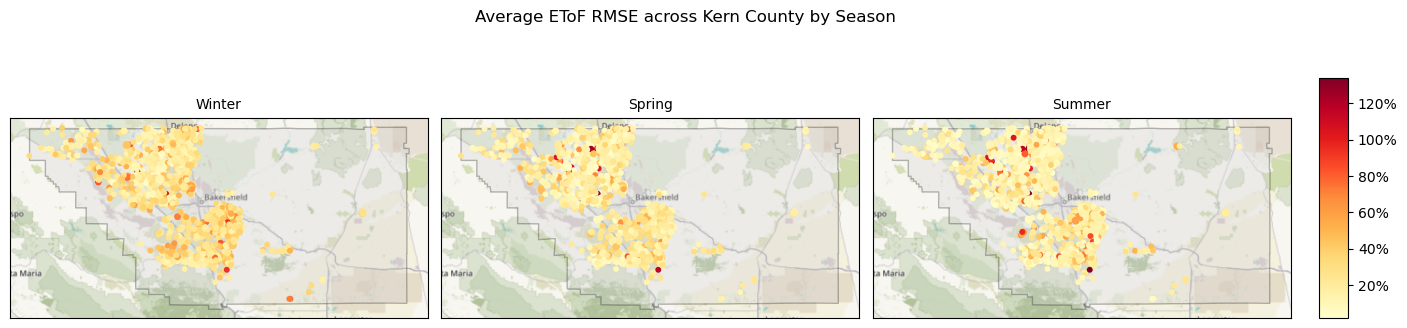

In [59]:
catplot_geo(etof_seasonal, boundary_map=keco_geo, col='season', hue='rmse', size='markersize', export_img="kern/etof_spatial_rmse",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF RMSE across Kern County by Season", background=True);

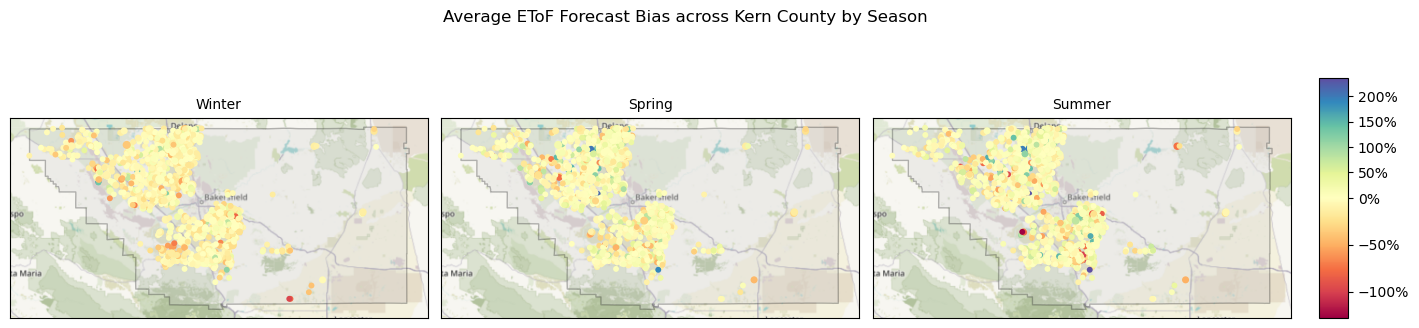

In [60]:
catplot_geo(etof_seasonal, boundary_map=keco_geo, col='season', hue='bias', size='markersize', palette='Spectral', export_img="kern/etof_spatial_bias",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Bias across Kern County by Season", background=True);

#### Summer Overview

In [61]:
summer_metrics = seasonal_metrics[seasonal_metrics['season'] == 'Summer'][['field_id', 'variable', 'longitude', 'latitude', 'mae', 'bias', 'skill_score', 'markersize']]
summer_metrics = summer_metrics.melt(id_vars=['field_id', 'variable', 'longitude', 'latitude', 'markersize'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
summer_metrics.head()

field_id variable   longitude   latitude  markersize stat  value
0   CA_27267       ET -119.969497  35.792434         2.0  mae   0.30
1   CA_27267      ETo -119.969497  35.792434         2.0  mae   0.18
2   CA_27267     ETof -119.969497  35.792434         2.0  mae   0.24
3  CA_297922       ET -119.229705  35.750524         2.0  mae   0.48
4  CA_297922      ETo -119.229705  35.750524         2.0  mae   0.17

In [62]:
# Add subtitles into the data to insert into the plots
subtitle_dict = {
    'mae': 'Mean Absolute Error',
    'bias': 'Forecast Bias',
    'skill_score': 'Skill Score'
}
summer_metrics['name'] = summer_metrics['stat'].map(subtitle_dict)

In [63]:
# Keyword for double-sided legend
sm_skill_score = summer_metrics[summer_metrics['stat'] == 'skill_score']

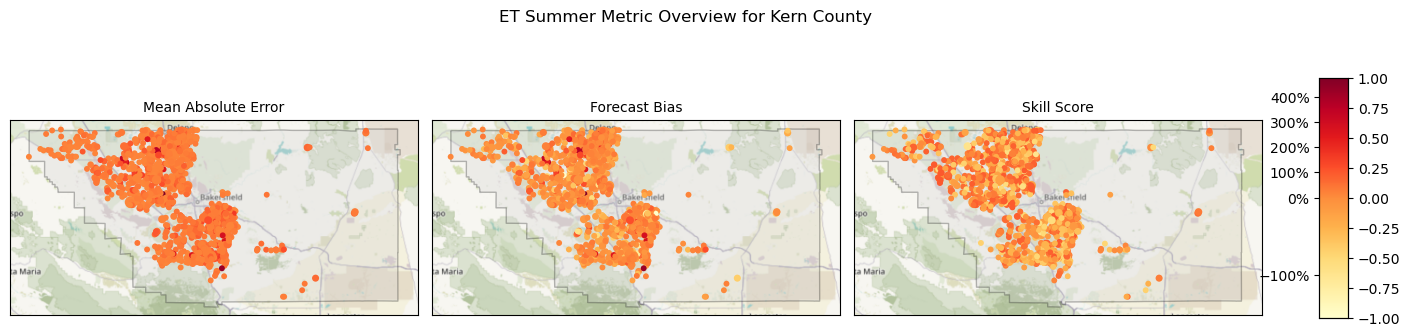

In [64]:
# Create subplot grid for each metric
g = catplot_geo(summer_metrics[summer_metrics['variable'] == 'ET'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ET Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="kern/et_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ET'], background=True);

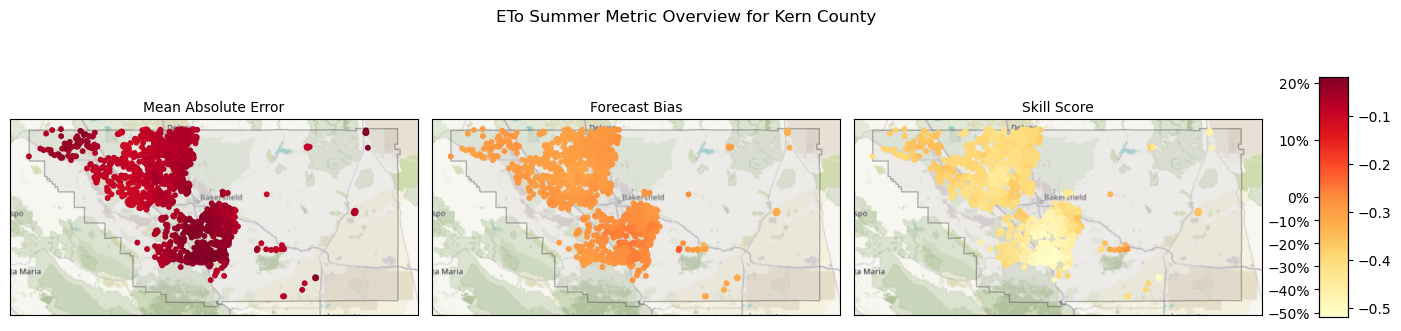

In [65]:
# Create subplot grid for each metric
g = catplot_geo(summer_metrics[summer_metrics['variable'] == 'ETo'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ETo Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="kern/eto_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETo'], background=True);

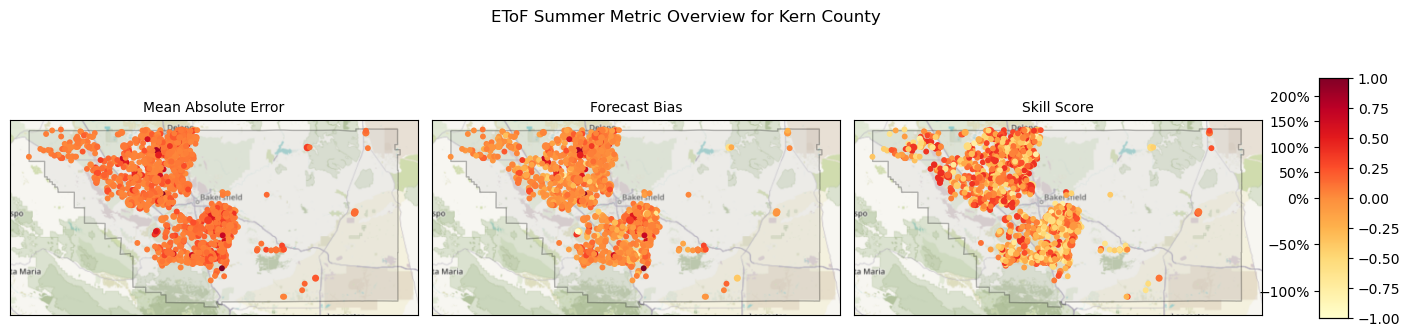

In [66]:
##### Create subplot grid for each metric
g = catplot_geo(summer_metrics[summer_metrics['variable'] == 'ETof'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='EToF Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="kern/etof_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETof'], background=True);